In [14]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
import pickle
import numpy as np
import pandas as pd

# import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
import seaborn as sns

from olympus.objects import (
        ParameterContinuous,
        ParameterDiscrete,
        ParameterCategorical,
)
from olympus.planners import Planner
from olympus.campaigns import Campaign, ParameterSpace
from olympus.surfaces import Surface

from olympus.utils.misc import get_hypervolume

from atlas.optimizers.gp.planner import BoTorchPlanner

In [16]:
def surface(x, s):
    if s == '0':
        return  np.sin(x[0])+ 12*np.cos(x[1]) - 0.1*x[2]
    elif s == '1':
        return 3*np.sin(x[0])+ 0.01*np.cos(x[1]) + 1.*x[2]**2
    elif s == '2':
        return 5*np.cos(x[0])+ 0.01*np.cos(x[1]) + 2.*x[2]**3
    
    
def moo_surface(x, s):
    if s == '0':
        return  np.array([
                    np.sin(x[0])+ 12*np.cos(x[1]) - 0.1*x[2],
                    np.sin(x[0])+ 12*np.cos(x[1]) - 0.1*x[2],
                ])
    elif s == '1':
        return  np.array([
                    3*np.sin(x[0])+ 0.01*np.cos(x[1]) + 1.*x[2]**2,
                    3*np.sin(x[0])+ 0.01*np.cos(x[1]) + 1.*x[2]**2,
                ])
    elif s == '2':
        return np.array([
                    5*np.cos(x[0])+ 0.01*np.cos(x[1]) + 2.*x[2]**3,
                    5*np.cos(x[0])+ 0.01*np.cos(x[1]) + 2.*x[2]**3,
                ])
    

In [17]:
# evaluate the surface for the best points 
p1_domain = np.linspace(0, 1, 100)
p2_domain = np.linspace(0, 1, 100)
p3_domain = np.linspace(0, 1, 100)

params = []
measurements = []

for p1 in p1_domain:
    for p2 in p2_domain:
        for p3 in p3_domain:
            vals = []
            x = [p1, p2, p3]
            for s in ['0', '1', '2']:
                vals.append(surface(x, s))
            measurements.append(np.mean(vals))
            params.append(x)

            

In [18]:
best_ix = np.argmin(measurements)
best_val = measurements[best_ix]
best_params = params[best_ix]

In [19]:
best_ix, best_val, best_params

(9904, 3.830719239025027, [0.0, 1.0, 0.04040404040404041])

In [21]:
# make parameter space
param_space = ParameterSpace()

# add ligand --> general parameter
param_space.add(
    ParameterCategorical(
        name='param_0',
        options=[str(i) for i in range(3)],
        descriptors=[None for i in range(3)],        # add descriptors later
    )
)
# add temperature
param_space.add(
    ParameterContinuous(
        name='param_1',
        low=0.,
        high=1.
    )
)
# add residence time
param_space.add(
    ParameterContinuous(
        name='param_2',
        low=0.,
        high=1.
    )
)
# add catalyst loading
# summit expects this to be in nM
param_space.add(
    ParameterContinuous(
        name='param_3',
        low=0.,
        high=1.,
    )
)



In [39]:
BUDGET = 20
NUM_RUNS = 10

In [40]:
all_campaigns = []
all_true_measurements = []

for run in range(NUM_RUNS):
    
    campaign = Campaign()
    campaign.set_param_space(param_space)

    planner = BoTorchPlanner(
        goal='minimize',
        init_design_strategy='random',
        num_init_design=5,
        batch_size=1,
        use_descriptors=False,
        acquisition_type='general',
        acquisition_optimizer_kind='genetic',
        general_parameters=[0],
        
    )
    planner.set_param_space(param_space)

    true_measurements = []

    iter_=0
    while len(campaign.observations.get_values())<BUDGET:

        samples = planner.recommend(campaign.observations)
        for sample in samples:
            measurement = surface(
                [float(sample.param_1), float(sample.param_2), float(sample.param_3)],
                sample.param_0,
            )

            all_measurements = []
            for s in param_space[0].options:
                all_measurements.append(
                    surface(
                        [float(sample.param_1), float(sample.param_2), float(sample.param_3)],
                        s,
                    )
                )
            true_measurement = np.mean(all_measurements)
            true_measurements.append(true_measurement)


            print(f'RUN # : {run+1}\t ITER : {iter_}\tSAMPLES : {samples}\t SINGLE MEASUREMENT : {measurement}\t TRUE MEASUREMENT : {true_measurement}')
            campaign.add_observation(sample, measurement)
        iter_ +=1
    
    all_true_measurements.append(true_measurements)
        
    all_campaigns.append(campaign)

[INFO] Generating 1 initial design points (batch 1/5)

ITER : 0	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.667973095726979, param_2 = 0.3534286492403307, param_3 = 0.8468303769711396)]	 MEASUREMENT : 2.5846915456246675


[INFO] Generating 1 initial design points (batch 2/5)

ITER : 1	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.6686140795322232, param_2 = 0.1693111102963305, param_3 = 0.9233627396212826)]	 MEASUREMENT : 12.3559757747211


[INFO] Generating 1 initial design points (batch 3/5)

ITER : 2	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7899074605097898, param_2 = 0.014924879968537197, param_3 = 0.7881760134690181)]	 MEASUREMENT : 4.5088177856340055


[INFO] Generating 1 initial design points (batch 4/5)

ITER : 3	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7226725040552175, param_2 = 0.49182416584426447, param_3 = 0.6137139353319362)]	 MEASUREMENT : 4.22132323806464


[INFO] Generating 1 initial design points (batch 5/5)

ITER : 4	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.3870947909240535, param_2 = 0.10632666786713052, param_3 = 0.04485623618098056)]	 MEASUREMENT : 12.305245856360003


[INFO] Regression surrogate GP trained in 0.349 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

[WARNING] Proposed parameter -0.7993706800208785 not within defined bounds (0.0,1.0)


ITER : 5	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.05565835578907896, param_2 = 0.9967835597839256, param_3 = -0.7993706800208785)]	 MEASUREMENT : 0.8113124145812022


[INFO] Regression surrogate GP trained in 0.377 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

ITER : 6	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.0005887744187798027, param_2 = 0.9967835597839256, param_3 = 1.416292682073756)]	 MEASUREMENT : 10.687269577366203


[WARNING] Proposed parameter 1.416292682073756 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.059 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

ITER : 7	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0005887744187798027, param_2 = 0.8644986355135721, param_3 = 1.8567202602916413)]	 MEASUREMENT : 7.603176191756652


[WARNING] Proposed parameter 1.8567202602916413 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.147 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

ITER : 8	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9949147150886719, param_2 = 0.9967835597839256, param_3 = -0.6261266190591973)]	 MEASUREMENT : 2.9136021792847084


[WARNING] Proposed parameter -0.6261266190591973 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.143 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

ITER : 9	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9949147150886719, param_2 = 0.9967835597839256, param_3 = -0.7333304609249488)]	 MEASUREMENT : 7.428118141025936


[WARNING] Proposed parameter -0.7333304609249488 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.128 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

ITER : 10	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.1578381738671122, param_2 = 0.10116749682965487, param_3 = 0.03175822018188701)]	 MEASUREMENT : 4.94785990337643


[INFO] Regression surrogate GP trained in 0.127 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

[WARNING] Proposed parameter -0.5390099426676362 not within defined bounds (0.0,1.0)


ITER : 11	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9949393102099992, param_2 = 0.6659724249171606, param_3 = -0.5390099426676362)]	 MEASUREMENT : 10.328423346990201


[INFO] Regression surrogate GP trained in 0.217 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

ITER : 12	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0005887744187798027, param_2 = 0.4483991956102391, param_3 = -0.0914101587942876)]	 MEASUREMENT : 10.823436706989709


[WARNING] Proposed parameter -0.0914101587942876 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.166 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

[WARNING] Proposed parameter -0.6263854707785557 not within defined bounds (0.0,1.0)


ITER : 13	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0005887744187798027, param_2 = 0.9967835597839256, param_3 = -0.6263854707785557)]	 MEASUREMENT : 6.579299891157572


[INFO] Regression surrogate GP trained in 0.274 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

[WARNING] Proposed parameter -0.42517937088504804 not within defined bounds (0.0,1.0)


ITER : 14	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9949393102099992, param_2 = 0.0026047507968717243, param_3 = -0.42517937088504804)]	 MEASUREMENT : 2.706955220078886


[INFO] Regression surrogate GP trained in 0.368 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

[WARNING] Proposed parameter -0.335070759474669 not within defined bounds (0.0,1.0)


ITER : 15	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9949393102099992, param_2 = 0.0026047507968717243, param_3 = -0.335070759474669)]	 MEASUREMENT : 12.872192286468966


[INFO] Regression surrogate GP trained in 0.247 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

ITER : 16	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.4521126963623042, param_2 = 0.018469059114216035, param_3 = 0.12416626589871982)]	 MEASUREMENT : 1.3360163559531182


[INFO] Regression surrogate GP trained in 0.365 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

[WARNING] Proposed parameter 1.1011516927850948 not within defined bounds (0.0,1.0)


ITER : 17	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.4926790020818378, param_2 = 0.5256085790332878, param_3 = 1.1011516927850948)]	 MEASUREMENT : 2.6401491422297014


[INFO] Regression surrogate GP trained in 0.307 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

ITER : 18	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.4240937568847144, param_2 = 0.002073953712260268, param_3 = 0.4247768955610539)]	 MEASUREMENT : 4.720349674289763


[INFO] Regression surrogate GP trained in 0.885 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

ITER : 19	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.482608334520344, param_2 = 0.9967835597839256, param_3 = 1.2427368844964568)]	 MEASUREMENT : 8.272920394119133


[WARNING] Proposed parameter 1.2427368844964568 not within defined bounds (0.0,1.0)


[INFO] Generating 1 initial design points (batch 1/5)

ITER : 0	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.10196200985099502, param_2 = 0.024343480509771198, param_3 = 0.46898893431487476)]	 MEASUREMENT : 5.1903377320094375


[INFO] Generating 1 initial design points (batch 2/5)

ITER : 1	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.17892325119199282, param_2 = 0.5567245340011239, param_3 = 0.16861870619117925)]	 MEASUREMENT : 0.5708325245043908


[INFO] Generating 1 initial design points (batch 3/5)

ITER : 2	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.5933386362448745, param_2 = 0.5388932776136346, param_3 = 0.7220437229019586)]	 MEASUREMENT : 10.786253694808478


[INFO] Generating 1 initial design points (batch 4/5)

ITER : 3	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.13200022497349106, param_2 = 0.5946997284683362, param_3 = 0.7408062851894766)]	 MEASUREMENT : 5.777886250100029


[INFO] Generating 1 initial design points (batch 5/5)

ITER : 4	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6856895012213007, param_2 = 0.5737504667351655, param_3 = 0.3613411331908001)]	 MEASUREMENT : 2.038586598291477


[INFO] Regression surrogate GP trained in 0.124 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

ITER : 5	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.10196200985099502, param_2 = 0.05570921756969897, param_3 = 0.16835838165346415)]	 MEASUREMENT : 12.066333306926692


[INFO] Regression surrogate GP trained in 0.058 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

ITER : 6	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9606719279515236, param_2 = 0.5566105036722905, param_3 = 0.136194969946397)]	 MEASUREMENT : 2.878390181626714


[INFO] Regression surrogate GP trained in 0.391 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

ITER : 7	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.10196200985099502, param_2 = 0.40864729911304676, param_3 = 0.06440426936138342)]	 MEASUREMENT : 11.10725519752012


[INFO] Regression surrogate GP trained in 1.464 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

ITER : 8	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.06636912292493147, param_2 = 0.5946997284683362, param_3 = 0.9985453865306123)]	 MEASUREMENT : 9.90626706644889


[INFO] Regression surrogate GP trained in 1.157 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

[WARNING] Proposed parameter 1.0396253516431329 not within defined bounds (0.0,1.0)


ITER : 9	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9604478647152144, param_2 = 0.013221993246284036, param_3 = 1.0396253516431329)]	 MEASUREMENT : 3.5491650341856382


[INFO] Regression surrogate GP trained in 2.203 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

[WARNING] Proposed parameter -0.007970065324282696 not within defined bounds (0.0,1.0)


ITER : 10	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9606719279515236, param_2 = 0.9967813171228288, param_3 = -0.007970065324282696)]	 MEASUREMENT : 2.4642238436107697


[INFO] Regression surrogate GP trained in 0.81 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

[WARNING] Proposed parameter -0.08571553524929089 not within defined bounds (0.0,1.0)


ITER : 11	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9979184847158005, param_2 = 0.9967813171228288, param_3 = -0.08571553524929089)]	 MEASUREMENT : 7.365011237118222


[INFO] Regression surrogate GP trained in 0.377 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

[WARNING] Proposed parameter -0.1658915196817065 not within defined bounds (0.0,1.0)


ITER : 12	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9979184847158005, param_2 = 0.010169229230102328, param_3 = -0.1658915196817065)]	 MEASUREMENT : 12.856313193166281


[INFO] Regression surrogate GP trained in 0.375 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

[WARNING] Proposed parameter -0.2517797185680536 not within defined bounds (0.0,1.0)


ITER : 13	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.02855389901745231, param_2 = 0.9967813171228288, param_3 = -0.2517797185680536)]	 MEASUREMENT : 4.97146974808669


[INFO] Regression surrogate GP trained in 0.448 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

[WARNING] Proposed parameter -0.1394572321797964 not within defined bounds (0.0,1.0)


ITER : 14	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.01520072725086119, param_2 = 0.9967813171228288, param_3 = -0.1394572321797964)]	 MEASUREMENT : 0.07047882453107696


[INFO] Regression surrogate GP trained in 0.317 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

[WARNING] Proposed parameter -0.08015049296752236 not within defined bounds (0.0,1.0)


ITER : 15	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.00021081737757089325, param_2 = 0.9967813171228288, param_3 = -0.08015049296752236)]	 MEASUREMENT : 6.524321035076266


[INFO] Regression surrogate GP trained in 0.881 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

ITER : 16	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.4842798920766125, param_2 = 0.9967813171228288, param_3 = 0.879207076661037)]	 MEASUREMENT : 5.789745359171647


[INFO] Regression surrogate GP trained in 0.39 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

[WARNING] Proposed parameter 1.0423195865071015 not within defined bounds (0.0,1.0)


ITER : 17	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9979184847158005, param_2 = 0.9990475216977858, param_3 = 1.0423195865071015)]	 MEASUREMENT : 3.6128747014208678


[INFO] Regression surrogate GP trained in 0.302 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

[WARNING] Proposed parameter 1.0450194423041683 not within defined bounds (0.0,1.0)


ITER : 18	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9979184847158005, param_2 = 0.9990475216977858, param_3 = 1.0450194423041683)]	 MEASUREMENT : 7.229085093160838


[INFO] Regression surrogate GP trained in 0.655 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

ITER : 19	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.00021081737757089325, param_2 = 0.9990475216977858, param_3 = 1.0477249307611833)]	 MEASUREMENT : 1.1037710181017222


[WARNING] Proposed parameter 1.0477249307611833 not within defined bounds (0.0,1.0)


[INFO] Generating 1 initial design points (batch 1/5)

ITER : 0	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.32121198822325847, param_2 = 0.4474117179897188, param_3 = 0.5924469020572471)]	 MEASUREMENT : 1.3071594050808768


[INFO] Generating 1 initial design points (batch 2/5)

ITER : 1	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.21550365150582662, param_2 = 0.7314667555077022, param_3 = 0.2661402055476728)]	 MEASUREMENT : 4.929487788073542


[INFO] Generating 1 initial design points (batch 3/5)

ITER : 2	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.22628426538995838, param_2 = 0.26111688441604797, param_3 = 0.3603620404647301)]	 MEASUREMENT : 4.975788705772252


[INFO] Generating 1 initial design points (batch 4/5)

ITER : 3	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.48471179055057834, param_2 = 0.7314180686389298, param_3 = 0.6671905594654723)]	 MEASUREMENT : 9.329970150507675


[INFO] Generating 1 initial design points (batch 5/5)

ITER : 4	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.7158704182150345, param_2 = 0.6263209288229762, param_3 = 0.5786840841979687)]	 MEASUREMENT : 10.320680491216264


[INFO] Regression surrogate GP trained in 0.554 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

ITER : 5	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.014912674447654317, param_2 = 0.24734636414485178, param_3 = 0.06321387190428118)]	 MEASUREMENT : 11.643377088812253


[INFO] Regression surrogate GP trained in 0.453 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

ITER : 6	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9793307503162306, param_2 = 0.9438405434490965, param_3 = 0.697026666449649)]	 MEASUREMENT : 3.471053460409259


[INFO] Regression surrogate GP trained in 0.954 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

ITER : 7	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.014912674447654317, param_2 = 0.17143566381173792, param_3 = 0.9990894004559369)]	 MEASUREMENT : 1.0527694038890076


[INFO] Regression surrogate GP trained in 1.126 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

[WARNING] Proposed parameter 1.0191469010745857 not within defined bounds (0.0,1.0)


ITER : 8	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9929905526078547, param_2 = 0.9438405434490965, param_3 = 1.0191469010745857)]	 MEASUREMENT : 3.5575165989551323


[INFO] Regression surrogate GP trained in 1.264 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

ITER : 9	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9996246064905376, param_2 = 0.6973529749989437, param_3 = 0.011823668485272387)]	 MEASUREMENT : 10.038622925813787


[INFO] Regression surrogate GP trained in 0.847 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

[WARNING] Proposed parameter 1.0195309242281079 not within defined bounds (0.0,1.0)


ITER : 10	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.25623839110011054, param_2 = 0.11840776419325238, param_3 = 1.0195309242281079)]	 MEASUREMENT : 12.067466316234466


[INFO] Regression surrogate GP trained in 0.824 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

[WARNING] Proposed parameter -0.0034372518018852775 not within defined bounds (0.0,1.0)


ITER : 11	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.014912674447654317, param_2 = 0.9998409253096079, param_3 = -0.0034372518018852775)]	 MEASUREMENT : 0.05015254142015652


[INFO] Regression surrogate GP trained in 0.683 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

[WARNING] Proposed parameter -0.018929286519036102 not within defined bounds (0.0,1.0)


ITER : 12	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.003178101161570912, param_2 = 0.9998409253096079, param_3 = -0.018929286519036102)]	 MEASUREMENT : 5.005365545357511


[INFO] Regression surrogate GP trained in 0.702 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

[WARNING] Proposed parameter -0.022241387615231166 not within defined bounds (0.0,1.0)


ITER : 13	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.003178101161570912, param_2 = 0.9998409253096079, param_3 = -0.022241387615231166)]	 MEASUREMENT : 6.490636103787297


[INFO] Regression surrogate GP trained in 1.082 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

[WARNING] Proposed parameter 1.0199233612695604 not within defined bounds (0.0,1.0)


ITER : 14	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9996246064905376, param_2 = 0.9998409253096079, param_3 = 1.0199233612695604)]	 MEASUREMENT : 7.224509632630945


[INFO] Regression surrogate GP trained in 0.825 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

[WARNING] Proposed parameter -0.025565304094143464 not within defined bounds (0.0,1.0)


ITER : 15	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9996246064905376, param_2 = 0.032807031065113956, param_3 = -0.025565304094143464)]	 MEASUREMENT : 2.5344525023808213


[INFO] Regression surrogate GP trained in 0.621 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

[WARNING] Proposed parameter -0.028899821987823062 not within defined bounds (0.0,1.0)


ITER : 16	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9996246064905376, param_2 = 0.01981394011471438, param_3 = -0.028899821987823062)]	 MEASUREMENT : 2.713040515542369


[INFO] Regression surrogate GP trained in 0.651 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

[WARNING] Proposed parameter -0.032244975108790756 not within defined bounds (0.0,1.0)


ITER : 17	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9996246064905376, param_2 = 0.013143438361768123, param_3 = -0.032244975108790756)]	 MEASUREMENT : 12.843456112143976


[INFO] Regression surrogate GP trained in 1.143 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

ITER : 18	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.03586930196539731, param_2 = 0.439903349212067, param_3 = 0.35340842082622553)]	 MEASUREMENT : 0.24153027271090438


[INFO] Regression surrogate GP trained in 0.411 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

ITER : 19	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.003178101161570912, param_2 = 0.9998409253096079, param_3 = 1.0203197145075418)]	 MEASUREMENT : 7.129791522238971


[WARNING] Proposed parameter 1.0203197145075418 not within defined bounds (0.0,1.0)


[INFO] Generating 1 initial design points (batch 1/5)

ITER : 0	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.7761262787156928, param_2 = 0.4897886721084326, param_3 = 0.6632504145875291)]	 MEASUREMENT : 11.22338277053165


[INFO] Generating 1 initial design points (batch 2/5)

ITER : 1	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.12210390003746252, param_2 = 0.2575820509765542, param_3 = 0.21621051901987498)]	 MEASUREMENT : 11.704284781556979


[INFO] Generating 1 initial design points (batch 3/5)

ITER : 2	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7737223942321425, param_2 = 0.8031715338879458, param_3 = 0.5871235608515275)]	 MEASUREMENT : 3.988295852311032


[INFO] Generating 1 initial design points (batch 4/5)

ITER : 3	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.2768632589380482, param_2 = 0.5711354366405975, param_3 = 0.2550652625707457)]	 MEASUREMENT : 10.343285760809705


[INFO] Generating 1 initial design points (batch 5/5)

ITER : 4	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8213363054988815, param_2 = 0.3351635015014309, param_3 = 0.41170358038528654)]	 MEASUREMENT : 12.023164987639559


[INFO] Regression surrogate GP trained in 0.371 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

ITER : 5	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9906322783448753, param_2 = 0.9984594523188908, param_3 = 0.967378917305765)]	 MEASUREMENT : 3.4503561580998734


[INFO] Regression surrogate GP trained in 0.327 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

ITER : 6	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9224980831298297, param_2 = 0.9085824463457862, param_3 = 0.9754807934658755)]	 MEASUREMENT : 8.077936002310734


[INFO] Regression surrogate GP trained in 0.574 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

ITER : 7	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9906322783448753, param_2 = 0.0005527489752219505, param_3 = 0.9836700540226986)]	 MEASUREMENT : 3.486724982201725


[INFO] Regression surrogate GP trained in 0.577 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

ITER : 8	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9906322783448753, param_2 = 0.0005527489752219505, param_3 = 0.9919476414780249)]	 MEASUREMENT : 4.702879595061026


[INFO] Regression surrogate GP trained in 0.902 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

ITER : 9	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9906322783448753, param_2 = 0.7396755209867422, param_3 = 0.9998321232342978)]	 MEASUREMENT : 9.600637269377751


[INFO] Regression surrogate GP trained in 0.769 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

[WARNING] Proposed parameter 1.008284029901591 not within defined bounds (0.0,1.0)


ITER : 10	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.03952438089342347, param_2 = 0.9996102012108179, param_3 = 1.008284029901591)]	 MEASUREMENT : 7.051618436672291


[INFO] Regression surrogate GP trained in 0.435 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

[WARNING] Proposed parameter 1.016085407390689 not within defined bounds (0.0,1.0)


ITER : 11	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.020025909204806847, param_2 = 0.9996102012108179, param_3 = 1.016085407390689)]	 MEASUREMENT : 6.405979260169583


[INFO] Regression surrogate GP trained in 0.338 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

[WARNING] Proposed parameter 1.0238053378859844 not within defined bounds (0.0,1.0)


ITER : 12	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9906322783448753, param_2 = 0.0005527489752219505, param_3 = 1.0238053378859844)]	 MEASUREMENT : 12.733990369205658


[INFO] Regression surrogate GP trained in 0.68 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

ITER : 13	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.020025909204806847, param_2 = 0.0005527489752219505, param_3 = 0.02368592690725646)]	 MEASUREMENT : 0.07063473373506789


[INFO] Regression surrogate GP trained in 0.421 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

ITER : 14	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.020025909204806847, param_2 = 0.0005527489752219505, param_3 = 0.09112779215684863)]	 MEASUREMENT : 5.0105109397815095


[INFO] Regression surrogate GP trained in 0.686 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

ITER : 15	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.011759194929207406, param_2 = 0.0005527489752219505, param_3 = 0.062494091503315086)]	 MEASUREMENT : 12.005507681584588


[INFO] Regression surrogate GP trained in 1.034 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

ITER : 16	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.011759194929207406, param_2 = 0.018375933848314683, param_3 = 0.30607533656297925)]	 MEASUREMENT : 0.13895719509527965


[INFO] Regression surrogate GP trained in 0.702 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

ITER : 17	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.4174331940598302, param_2 = 0.9996102012108179, param_3 = 0.0015172966421411749)]	 MEASUREMENT : 1.2216547756447869


[INFO] Regression surrogate GP trained in 0.491 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

[WARNING] Proposed parameter -0.010763441474449343 not within defined bounds (0.0,1.0)


ITER : 18	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.38356366233153905, param_2 = 0.9996102012108179, param_3 = -0.010763441474449343)]	 MEASUREMENT : 4.642088339764412


[INFO] Regression surrogate GP trained in 0.574 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

ITER : 19	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.008293863363430187, param_2 = 0.9996102012108179, param_3 = -0.023191708000454468)]	 MEASUREMENT : 6.4981761692760855


[WARNING] Proposed parameter -0.023191708000454468 not within defined bounds (0.0,1.0)


[INFO] Generating 1 initial design points (batch 1/5)

ITER : 0	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7487009715741174, param_2 = 0.925797433238839, param_3 = 0.33637957850112454)]	 MEASUREMENT : 3.7450040924698804


[INFO] Generating 1 initial design points (batch 2/5)

ITER : 1	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.7933963452723133, param_2 = 0.6821401731580332, param_3 = 0.44543905726010946)]	 MEASUREMENT : 9.982898323423829


[INFO] Generating 1 initial design points (batch 3/5)

ITER : 2	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9788626788907943, param_2 = 0.8807524503010469, param_3 = 0.9167148789482858)]	 MEASUREMENT : 4.336951695004234


[INFO] Generating 1 initial design points (batch 4/5)

ITER : 3	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8993496481191983, param_2 = 0.7048675965681981, param_3 = 0.6068544476069291)]	 MEASUREMENT : 9.862605197894105


[INFO] Generating 1 initial design points (batch 5/5)

ITER : 4	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.6260920277465923, param_2 = 0.4348925067700401, param_3 = 0.8403934704295472)]	 MEASUREMENT : 11.384927200979034


[INFO] Regression surrogate GP trained in 0.818 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

[WARNING] Proposed parameter -0.693590762784918 not within defined bounds (0.0,1.0)


ITER : 5	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.2465262293576227, param_2 = 0.0031274419349642812, param_3 = -0.693590762784918)]	 MEASUREMENT : 1.2231781786490772


[INFO] Regression surrogate GP trained in 0.684 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

[WARNING] Proposed parameter -0.7881696439364891 not within defined bounds (0.0,1.0)


ITER : 6	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9002723550699714, param_2 = 0.0031274419349642812, param_3 = -0.7881696439364891)]	 MEASUREMENT : 12.862254458282406


[INFO] Regression surrogate GP trained in 0.603 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

[WARNING] Proposed parameter -0.3346213706450126 not within defined bounds (0.0,1.0)


ITER : 7	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.014390330629878267, param_2 = 0.9944542218415716, param_3 = -0.3346213706450126)]	 MEASUREMENT : 0.16059056945796513


[INFO] Regression surrogate GP trained in 0.786 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

ITER : 8	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.013197694325712273, param_2 = 0.9944542218415716, param_3 = 0.9540789791929543)]	 MEASUREMENT : 6.457316429699717


[INFO] Regression surrogate GP trained in 0.548 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

[WARNING] Proposed parameter -0.8119808674233786 not within defined bounds (0.0,1.0)


ITER : 9	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9954054752820932, param_2 = 0.9944542218415716, param_3 = -0.8119808674233786)]	 MEASUREMENT : 3.181701573936177


[INFO] Regression surrogate GP trained in 0.685 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

ITER : 10	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.013197694325712273, param_2 = 0.0031274419349642812, param_3 = 0.9623402054156154)]	 MEASUREMENT : 6.79200848006958


[INFO] Regression surrogate GP trained in 0.573 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

ITER : 11	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.007059686498713358, param_2 = 0.0031274419349642812, param_3 = 0.9706400757752986)]	 MEASUREMENT : 11.909936934969334


[INFO] Regression surrogate GP trained in 0.527 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

ITER : 12	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.7360950121605432, param_2 = 0.998757156830784, param_3 = 0.9789269198262991)]	 MEASUREMENT : 7.069678832431531


[INFO] Regression surrogate GP trained in 0.562 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

ITER : 13	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.933390617456116, param_2 = 0.658550676256824, param_3 = 0.2375666631110347)]	 MEASUREMENT : 2.47527378602715


[INFO] Regression surrogate GP trained in 1.019 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

ITER : 14	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5666366224805841, param_2 = 0.44648431442047654, param_3 = 0.39425692088568587)]	 MEASUREMENT : 1.7748503400912483


[INFO] Regression surrogate GP trained in 1.587 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

[WARNING] Proposed parameter -0.19724375834511565 not within defined bounds (0.0,1.0)


ITER : 15	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.007059686498713358, param_2 = 0.5539947465516093, param_3 = -0.19724375834511565)]	 MEASUREMENT : 4.99303212344018


[INFO] Regression surrogate GP trained in 0.79 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

ITER : 16	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7326506892884042, param_2 = 0.998757156830784, param_3 = 0.7470373880162589)]	 MEASUREMENT : 2.570005883344008


[INFO] Regression surrogate GP trained in 0.933 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

ITER : 17	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.23097553745804997, param_2 = 0.07191623812404957, param_3 = 0.7788529467832914)]	 MEASUREMENT : 5.822114758561306


[INFO] Regression surrogate GP trained in 0.273 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

ITER : 18	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0033839702139287775, param_2 = 0.5895329649046094, param_3 = 0.019857434590256795)]	 MEASUREMENT : 0.018858213260861803


[INFO] Regression surrogate GP trained in 0.595 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

ITER : 19	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0033839702139287775, param_2 = 0.5859012385873438, param_3 = -0.06755806932627495)]	 MEASUREMENT : 10.008708778445346


[WARNING] Proposed parameter -0.06755806932627495 not within defined bounds (0.0,1.0)


[INFO] Generating 1 initial design points (batch 1/5)

ITER : 0	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.6097784832428991, param_2 = 0.9628730730470177, param_3 = 0.011005963984995093)]	 MEASUREMENT : 7.425553584147343


[INFO] Generating 1 initial design points (batch 2/5)

ITER : 1	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.11877077696207272, param_2 = 0.7995189580092602, param_3 = 0.9819031003792486)]	 MEASUREMENT : 8.384921909386255


[INFO] Generating 1 initial design points (batch 3/5)

ITER : 2	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.35412893663615097, param_2 = 0.4228512811086076, param_3 = 0.053713147528824945)]	 MEASUREMENT : 4.699173693215958


[INFO] Generating 1 initial design points (batch 4/5)

ITER : 3	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6724554068550479, param_2 = 0.6805271623683297, param_3 = 0.050065113303957354)]	 MEASUREMENT : 1.8790050695945189


[INFO] Generating 1 initial design points (batch 5/5)

ITER : 4	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6815422306925929, param_2 = 0.25410224413983473, param_3 = 0.00044790761098689735)]	 MEASUREMENT : 1.8996535110404817


[INFO] Regression surrogate GP trained in 0.663 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

[WARNING] Proposed parameter 1.5251639257942526 not within defined bounds (0.0,1.0)


ITER : 5	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9979346760779899, param_2 = 0.3279258040958284, param_3 = 1.5251639257942526)]	 MEASUREMENT : 9.8151063120075


[INFO] Regression surrogate GP trained in 0.535 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

ITER : 6	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9979346760779899, param_2 = 0.25410224413983473, param_3 = 0.4756529489876553)]	 MEASUREMENT : 2.935103101134021


[INFO] Regression surrogate GP trained in 0.203 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

ITER : 7	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9691063729332184, param_2 = 0.25410224413983473, param_3 = 0.4726705317982126)]	 MEASUREMENT : 12.391785489903711


[INFO] Regression surrogate GP trained in 0.306 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

ITER : 8	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.013362085558343062, param_2 = 0.9628730730470177, param_3 = -0.2055338304730161)]	 MEASUREMENT : 6.887883371256161


[WARNING] Proposed parameter -0.2055338304730161 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.141 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

ITER : 9	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9979346760779899, param_2 = 0.25410224413983473, param_3 = 1.5287944552476536)]	 MEASUREMENT : 4.86795125495314


[WARNING] Proposed parameter 1.5287944552476536 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.156 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

ITER : 10	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.013362085558343062, param_2 = 0.010318874335472072, param_3 = 1.3377148862048454)]	 MEASUREMENT : 11.878951329981989


[WARNING] Proposed parameter 1.3377148862048454 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.134 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

ITER : 11	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.013362085558343062, param_2 = 0.3468709789123845, param_3 = 0.765409988433615)]	 MEASUREMENT : 0.6353419246804166


[INFO] Regression surrogate GP trained in 0.18 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

[WARNING] Proposed parameter -0.2290711938522475 not within defined bounds (0.0,1.0)


ITER : 12	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.013362085558343062, param_2 = 0.00043055542359549115, param_3 = -0.2290711938522475)]	 MEASUREMENT : 12.036267695056301


[INFO] Regression surrogate GP trained in 0.218 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

[WARNING] Proposed parameter -0.2529279935685365 not within defined bounds (0.0,1.0)


ITER : 13	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5178616437086767, param_2 = 0.557651604294382, param_3 = -0.2529279935685365)]	 MEASUREMENT : 4.320522602360312


[INFO] Regression surrogate GP trained in 1.024 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

[WARNING] Proposed parameter 1.5325320205185327 not within defined bounds (0.0,1.0)


ITER : 14	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7232784282085379, param_2 = 0.9673802449153767, param_3 = 1.5325320205185327)]	 MEASUREMENT : 4.339866575105731


[INFO] Regression surrogate GP trained in 0.85 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

[WARNING] Proposed parameter -0.277159289048557 not within defined bounds (0.0,1.0)


ITER : 15	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.5761505434394962, param_2 = 0.5692109018208831, param_3 = -0.277159289048557)]	 MEASUREMENT : 10.680434314655647


[INFO] Regression surrogate GP trained in 1.196 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

ITER : 16	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.03272690372893952, param_2 = 0.9926948462198368, param_3 = 0.6330469227634505)]	 MEASUREMENT : 5.510172053480121


[INFO] Regression surrogate GP trained in 0.78 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

ITER : 17	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.012135227540884364, param_2 = 0.9926948462198368, param_3 = 0.6274029986079499)]	 MEASUREMENT : 6.5066135440144155


[INFO] Regression surrogate GP trained in 1.439 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

ITER : 18	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.018931521660760252, param_2 = 0.9926948462198368, param_3 = 1.5363235106877766)]	 MEASUREMENT : 6.422516953940073


[WARNING] Proposed parameter 1.5363235106877766 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.189 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

ITER : 19	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9979346760779899, param_2 = 0.9926948462198368, param_3 = 1.5401229444204492)]	 MEASUREMENT : 10.021937250894178


[WARNING] Proposed parameter 1.5401229444204492 not within defined bounds (0.0,1.0)


[INFO] Generating 1 initial design points (batch 1/5)

ITER : 0	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.6297236243671208, param_2 = 0.5355019793133855, param_3 = 0.07735448036987491)]	 MEASUREMENT : 4.05047737386659


[INFO] Generating 1 initial design points (batch 2/5)

ITER : 1	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9670136503578148, param_2 = 0.4535784322817529, param_3 = 0.4777335932859591)]	 MEASUREMENT : 3.065856557462415


[INFO] Generating 1 initial design points (batch 3/5)

ITER : 2	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.4158902964190012, param_2 = 0.496345586925625, param_3 = 0.5822307715446002)]	 MEASUREMENT : 4.977322212914959


[INFO] Generating 1 initial design points (batch 4/5)

ITER : 3	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.909054580030436, param_2 = 0.9904100162163132, param_3 = 0.02058738063088461)]	 MEASUREMENT : 7.367028764528953


[INFO] Generating 1 initial design points (batch 5/5)

ITER : 4	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.5082146879961457, param_2 = 0.3452022303314517, param_3 = 0.148600610899718)]	 MEASUREMENT : 11.763842764228421


[INFO] Regression surrogate GP trained in 0.281 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

ITER : 5	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.018698277295073507, param_2 = 0.9995438723029553, param_3 = 0.9212192932175529)]	 MEASUREMENT : 0.9101434101193611


[INFO] Regression surrogate GP trained in 0.606 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

ITER : 6	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9892513540257113, param_2 = 0.002895293911128083, param_3 = 0.03274337288528151)]	 MEASUREMENT : 2.5179169962530183


[INFO] Regression surrogate GP trained in 0.601 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

ITER : 7	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.018698277295073507, param_2 = 0.002895293911128083, param_3 = 0.9911043986602578)]	 MEASUREMENT : 6.956225694070042


[INFO] Regression surrogate GP trained in 1.481 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

ITER : 8	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.005791800555799753, param_2 = 0.9995438723029553, param_3 = 0.001889797444863086)]	 MEASUREMENT : 5.005323012027148


[INFO] Regression surrogate GP trained in 0.423 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

ITER : 9	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0050312813892341435, param_2 = 0.9995438723029553, param_3 = 0.5882339102802187)]	 MEASUREMENT : 6.434440683594186


[INFO] Regression surrogate GP trained in 0.386 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

[WARNING] Proposed parameter 1.0019076127389874 not within defined bounds (0.0,1.0)


ITER : 10	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0050312813892341435, param_2 = 0.02029849521564145, param_3 = 1.0019076127389874)]	 MEASUREMENT : 1.028910584877909


[INFO] Regression surrogate GP trained in 0.305 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

[WARNING] Proposed parameter 1.0128288087341664 not within defined bounds (0.0,1.0)


ITER : 11	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0050312813892341435, param_2 = 0.002895293911128083, param_3 = 1.0128288087341664)]	 MEASUREMENT : 11.903698082963187


[INFO] Regression surrogate GP trained in 0.315 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

[WARNING] Proposed parameter 1.023869275126473 not within defined bounds (0.0,1.0)


ITER : 12	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9893388037320977, param_2 = 0.002895293911128083, param_3 = 1.023869275126473)]	 MEASUREMENT : 12.733225780353276


[INFO] Regression surrogate GP trained in 0.532 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

[WARNING] Proposed parameter 1.0349384550646936 not within defined bounds (0.0,1.0)


ITER : 13	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0050312813892341435, param_2 = 0.6619637590147914, param_3 = 1.0349384550646936)]	 MEASUREMENT : 1.0940792532119061


[INFO] Regression surrogate GP trained in 0.425 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

ITER : 14	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0050312813892341435, param_2 = 0.6412424695005312, param_3 = 0.928542791169019)]	 MEASUREMENT : 9.528414683170006


[INFO] Regression surrogate GP trained in 0.217 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

ITER : 15	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9893388037320977, param_2 = 0.65720894687719, param_3 = 1.0313150324630465)]	 MEASUREMENT : 3.5785167126993036


[WARNING] Proposed parameter 1.0313150324630465 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.185 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

[WARNING] Proposed parameter 1.0461275265928927 not within defined bounds (0.0,1.0)


ITER : 16	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9893388037320977, param_2 = 0.6508485848686106, param_3 = 1.0461275265928927)]	 MEASUREMENT : 10.277889770999936


[INFO] Regression surrogate GP trained in 0.506 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

ITER : 17	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.1432569227534979, param_2 = 0.2029574173019073, param_3 = 0.6908240701708154)]	 MEASUREMENT : 0.9153349209149169


[INFO] Regression surrogate GP trained in 0.479 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

[WARNING] Proposed parameter 1.0259678583282386 not within defined bounds (0.0,1.0)


ITER : 18	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.44562740752034125, param_2 = 0.9012962552831065, param_3 = 1.0259678583282386)]	 MEASUREMENT : 2.3518882876505636


[INFO] Regression surrogate GP trained in 0.541 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

ITER : 19	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.4353296966237154, param_2 = 0.8911566243704522, param_3 = 0.985049819184333)]	 MEASUREMENT : 6.451573684968755


[INFO] Generating 1 initial design points (batch 1/5)

ITER : 0	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.16857027157833482, param_2 = 0.5175949501893227, param_3 = 0.006250648969261863)]	 MEASUREMENT : 0.5120483617514029


[INFO] Generating 1 initial design points (batch 2/5)

ITER : 1	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.5392880036527841, param_2 = 0.892824596449921, param_3 = 0.02641956233360576)]	 MEASUREMENT : 8.037458474442507


[INFO] Generating 1 initial design points (batch 3/5)

ITER : 2	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.3027844037960773, param_2 = 0.3332861544854936, param_3 = 0.037122805602626596)]	 MEASUREMENT : 0.905365127120492


[INFO] Generating 1 initial design points (batch 4/5)

ITER : 3	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.30174995793745585, param_2 = 0.1844858030731612, param_3 = 0.19612657735727268)]	 MEASUREMENT : 4.799007966824135


[INFO] Generating 1 initial design points (batch 5/5)

ITER : 4	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.2240934151822861, param_2 = 0.12756194597251846, param_3 = 0.5979104039307463)]	 MEASUREMENT : 5.312400779800309


[INFO] Regression surrogate GP trained in 0.236 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

[WARNING] Proposed parameter 1.3331996134722433 not within defined bounds (0.0,1.0)


ITER : 5	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.012422740400523935, param_2 = 7.616843719104871e-05, param_3 = 1.3331996134722433)]	 MEASUREMENT : 11.879102424723825


[INFO] Regression surrogate GP trained in 0.462 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

[WARNING] Proposed parameter 2.214962941544676 not within defined bounds (0.0,1.0)


ITER : 6	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9926166533123574, param_2 = 0.7273792572732449, param_3 = 2.214962941544676)]	 MEASUREMENT : 9.578996972509911


[INFO] Regression surrogate GP trained in 0.339 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

ITER : 7	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0063831934783056266, param_2 = 0.61584230327079, param_3 = 0.6922453132051232)]	 MEASUREMENT : 9.73260481682392


[INFO] Regression surrogate GP trained in 0.552 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

ITER : 8	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9109692904773318, param_2 = 0.7649592702491601, param_3 = 0.30689881289952337)]	 MEASUREMENT : 3.129926803984255


[INFO] Regression surrogate GP trained in 0.779 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

ITER : 9	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.1593974572980359, param_2 = 0.663133273696643, param_3 = 0.42234404109282364)]	 MEASUREMENT : 5.095166978914012


[INFO] Regression surrogate GP trained in 0.953 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

[WARNING] Proposed parameter -0.008044787861562697 not within defined bounds (0.0,1.0)


ITER : 10	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9926166533123574, param_2 = 7.616843719104871e-05, param_3 = -0.008044787861562697)]	 MEASUREMENT : 12.838263289998794


[INFO] Regression surrogate GP trained in 2.211 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

[WARNING] Proposed parameter 1.275172921638814 not within defined bounds (0.0,1.0)


ITER : 11	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0063831934783056266, param_2 = 0.9864610168097893, param_3 = 1.275172921638814)]	 MEASUREMENT : 1.6507318814768126


[INFO] Regression surrogate GP trained in 0.852 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

[WARNING] Proposed parameter 1.7906905265806512 not within defined bounds (0.0,1.0)


ITER : 12	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.0063831934783056266, param_2 = 0.9864610168097893, param_3 = 1.7906905265806512)]	 MEASUREMENT : 16.48937280753374


[INFO] Regression surrogate GP trained in 0.605 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

[WARNING] Proposed parameter 1.1430267696000147 not within defined bounds (0.0,1.0)


ITER : 13	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9926166533123574, param_2 = 0.9983053969759397, param_3 = 1.1430267696000147)]	 MEASUREMENT : 7.223886033148665


[INFO] Regression surrogate GP trained in 1.735 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

[WARNING] Proposed parameter 2.2316054057550003 not within defined bounds (0.0,1.0)


ITER : 14	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9926166533123574, param_2 = 7.616843719104871e-05, param_3 = 2.2316054057550003)]	 MEASUREMENT : 24.969571599202215


[INFO] Regression surrogate GP trained in 2.712 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

ITER : 15	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9926166533123574, param_2 = 0.9990702969330432, param_3 = 0.3741061517331123)]	 MEASUREMENT : 2.657742794735888


[INFO] Regression surrogate GP trained in 0.905 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

ITER : 16	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9926166533123574, param_2 = 0.9990702969330432, param_3 = 0.4715548141288313)]	 MEASUREMENT : 7.283316049484368


[INFO] Regression surrogate GP trained in 0.801 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

[WARNING] Proposed parameter 1.3099844455094594 not within defined bounds (0.0,1.0)


ITER : 17	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0063831934783056266, param_2 = 0.9990702969330432, param_3 = 1.3099844455094594)]	 MEASUREMENT : 6.368397390454904


[INFO] Regression surrogate GP trained in 1.115 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

ITER : 18	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.003210941454717675, param_2 = 0.9990702969330432, param_3 = 0.30759817978865595)]	 MEASUREMENT : 0.10966029192488219


[INFO] Regression surrogate GP trained in 1.225 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

ITER : 19	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.003210941454717675, param_2 = 7.616843719104871e-05, param_3 = -0.015313177111583122)]	 MEASUREMENT : 12.004742218838551


[WARNING] Proposed parameter -0.015313177111583122 not within defined bounds (0.0,1.0)


[INFO] Generating 1 initial design points (batch 1/5)

ITER : 0	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.7701138045063786, param_2 = 0.677816332827818, param_3 = 0.3819072916967665)]	 MEASUREMENT : 10.005353467882555


[INFO] Generating 1 initial design points (batch 2/5)

ITER : 1	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9408579934220755, param_2 = 0.6377505907697149, param_3 = 0.5282515218163082)]	 MEASUREMENT : 2.711275552983457


[INFO] Generating 1 initial design points (batch 3/5)

ITER : 2	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0972020124790729, param_2 = 0.0833556132424258, param_3 = 0.27302998996316796)]	 MEASUREMENT : 0.37565771551051463


[INFO] Generating 1 initial design points (batch 4/5)

ITER : 3	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.05106463912382975, param_2 = 0.28589798345070183, param_3 = 0.13290460944401306)]	 MEASUREMENT : 11.550657480760773


[INFO] Generating 1 initial design points (batch 5/5)

ITER : 4	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.32528120595435694, param_2 = 0.4587254494405282, param_3 = 0.8343142929889782)]	 MEASUREMENT : 5.908270215719538


[INFO] Regression surrogate GP trained in 0.207 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

ITER : 5	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.05106463912382975, param_2 = 0.9771907763176777, param_3 = 0.9812112473524877)]	 MEASUREMENT : 6.888448278981566


[INFO] Regression surrogate GP trained in 0.318 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

[WARNING] Proposed parameter 1.0375957854282585 not within defined bounds (0.0,1.0)


ITER : 6	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9908447472268209, param_2 = 0.040050784094334047, param_3 = 1.0375957854282585)]	 MEASUREMENT : 4.984070802145812


[INFO] Regression surrogate GP trained in 0.401 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

ITER : 7	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9963866941892915, param_2 = 0.0004223349209532268, param_3 = 1.0464091985228516)]	 MEASUREMENT : 12.734871228434


[WARNING] Proposed parameter 1.0464091985228516 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.162 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

ITER : 8	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9963866941892915, param_2 = 0.41958712074711707, param_3 = 0.8941300650422408)]	 MEASUREMENT : 3.32714080085651


[INFO] Regression surrogate GP trained in 1.539 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

ITER : 9	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0020046947451138886, param_2 = 0.9920904951576993, param_3 = 0.672962076626217)]	 MEASUREMENT : 0.46436144633078846


[INFO] Regression surrogate GP trained in 0.446 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

ITER : 10	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.443656172885029, param_2 = 0.9920904951576993, param_3 = 0.02548804977996766)]	 MEASUREMENT : 1.293852668139745


[INFO] Regression surrogate GP trained in 1.281 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

[WARNING] Proposed parameter 1.0501189580510095 not within defined bounds (0.0,1.0)


ITER : 11	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0020046947451138886, param_2 = 0.9985218389980672, param_3 = 1.0501189580510095)]	 MEASUREMENT : 6.3955393344754246


[INFO] Regression surrogate GP trained in 0.25 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

ITER : 12	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9963866941892915, param_2 = 0.9997565321031012, param_3 = 0.9923462732344345)]	 MEASUREMENT : 4.676529612349182


[INFO] Regression surrogate GP trained in 0.201 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

[WARNING] Proposed parameter 1.0538421978717185 not within defined bounds (0.0,1.0)


ITER : 13	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9963866941892915, param_2 = 0.9997565321031012, param_3 = 1.0538421978717185)]	 MEASUREMENT : 7.220214930981114


[INFO] Regression surrogate GP trained in 0.275 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

ITER : 14	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.0020046947451138886, param_2 = 0.9997565321031012, param_3 = 0.02341486652439243)]	 MEASUREMENT : 5.005420699291968


[INFO] Regression surrogate GP trained in 0.27 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

ITER : 15	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0020046947451138886, param_2 = 0.9997565321031012, param_3 = 0.0007532109616141813)]	 MEASUREMENT : 6.488015304587511


[INFO] Regression surrogate GP trained in 0.196 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

[WARNING] Proposed parameter -0.0013698382411765253 not within defined bounds (0.0,1.0)


ITER : 16	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9963866941892915, param_2 = 0.9997565321031012, param_3 = -0.0013698382411765253)]	 MEASUREMENT : 2.7221013873047646


[INFO] Regression surrogate GP trained in 0.332 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

[WARNING] Proposed parameter -0.003497167555119752 not within defined bounds (0.0,1.0)


ITER : 17	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9980896889715449, param_2 = 0.0004223349209532268, param_3 = -0.003497167555119752)]	 MEASUREMENT : 2.531324143081428


[INFO] Regression surrogate GP trained in 0.469 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

[WARNING] Proposed parameter -0.005625141145409996 not within defined bounds (0.0,1.0)


ITER : 18	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9980896889715449, param_2 = 0.0004223349209532268, param_3 = -0.005625141145409996)]	 MEASUREMENT : 2.7195435947930084


[INFO] Regression surrogate GP trained in 0.509 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

ITER : 19	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9980896889715449, param_2 = 0.9997565321031012, param_3 = -0.007757397439767675)]	 MEASUREMENT : 7.32729897662273


[WARNING] Proposed parameter -0.007757397439767675 not within defined bounds (0.0,1.0)


[INFO] Generating 1 initial design points (batch 1/5)

ITER : 0	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5623124237986353, param_2 = 0.5011410391402353, param_3 = 0.32585464779115547)]	 MEASUREMENT : 4.308092254276348


[INFO] Generating 1 initial design points (batch 2/5)

ITER : 1	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5456595472181562, param_2 = 0.3347475187535045, param_3 = 0.8324401942830948)]	 MEASUREMENT : 2.2593475335324076


[INFO] Generating 1 initial design points (batch 3/5)

ITER : 2	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8023973073323426, param_2 = 0.4458655895120621, param_3 = 0.7878745290043877)]	 MEASUREMENT : 4.4620876627486545


[INFO] Generating 1 initial design points (batch 4/5)

ITER : 3	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7742731653756083, param_2 = 0.7320400915358346, param_3 = 0.3044315098639506)]	 MEASUREMENT : 3.6385137779179995


[INFO] Generating 1 initial design points (batch 5/5)

ITER : 4	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.316711025360901, param_2 = 0.9728440128349842, param_3 = 0.5040933105384665)]	 MEASUREMENT : 5.013144298945971


[INFO] Regression surrogate GP trained in 0.11 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

ITER : 5	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8348194189329071, param_2 = 0.8024892010354424, param_3 = 0.7431324407177573)]	 MEASUREMENT : 9.005888964326324


[INFO] Regression surrogate GP trained in 0.113 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

[WARNING] Proposed parameter -0.018331413866396584 not within defined bounds (0.0,1.0)


ITER : 6	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.03680130790257463, param_2 = 0.011783448351374737, param_3 = -0.018331413866396584)]	 MEASUREMENT : 12.03779305467001


[INFO] Regression surrogate GP trained in 1.464 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

[WARNING] Proposed parameter 1.0085400940462412 not within defined bounds (0.0,1.0)


ITER : 7	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.01997110583441919, param_2 = 0.0021317926078198157, param_3 = 1.0085400940462412)]	 MEASUREMENT : 11.919088501665414


[INFO] Regression surrogate GP trained in 0.609 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

[WARNING] Proposed parameter -0.03952203400819411 not within defined bounds (0.0,1.0)


ITER : 8	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9897475245097901, param_2 = 0.0021317926078198157, param_3 = -0.03952203400819411)]	 MEASUREMENT : 2.7543811069424184


[INFO] Regression surrogate GP trained in 0.862 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

[WARNING] Proposed parameter -0.06110531876528953 not within defined bounds (0.0,1.0)


ITER : 9	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.995928533427482, param_2 = 0.9219270714837603, param_3 = -0.06110531876528953)]	 MEASUREMENT : 2.5275692994550685


[INFO] Regression surrogate GP trained in 0.338 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

[WARNING] Proposed parameter -0.08299356953286541 not within defined bounds (0.0,1.0)


ITER : 10	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9963375399674497, param_2 = 0.0021317926078198157, param_3 = -0.08299356953286541)]	 MEASUREMENT : 12.847758599779354


[INFO] Regression surrogate GP trained in 0.52 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

[WARNING] Proposed parameter -0.10532036504463173 not within defined bounds (0.0,1.0)


ITER : 11	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.013802957894878953, param_2 = 0.9851536114857514, param_3 = -0.10532036504463173)]	 MEASUREMENT : 0.058027289186786374


[INFO] Regression surrogate GP trained in 0.349 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

[WARNING] Proposed parameter -0.1209682303659409 not within defined bounds (0.0,1.0)


ITER : 12	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.010823115752142454, param_2 = 0.9945756975590239, param_3 = -0.1209682303659409)]	 MEASUREMENT : 6.56122446287181


[INFO] Regression surrogate GP trained in 0.255 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

[WARNING] Proposed parameter 1.0127377418578387 not within defined bounds (0.0,1.0)


ITER : 13	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.010823115752142454, param_2 = 0.9994086085795583, param_3 = 1.0127377418578387)]	 MEASUREMENT : 1.0635144456352243


[INFO] Regression surrogate GP trained in 0.507 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

ITER : 14	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.00802757983669189, param_2 = 0.9994086085795583, param_3 = 1.0169509895962092)]	 MEASUREMENT : 6.395930595575295


[WARNING] Proposed parameter 1.0169509895962092 not within defined bounds (0.0,1.0)


[INFO] Regression surrogate GP trained in 0.151 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

[WARNING] Proposed parameter -0.13021101635865412 not within defined bounds (0.0,1.0)


ITER : 15	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9963375399674497, param_2 = 0.9994086085795583, param_3 = -0.13021101635865412)]	 MEASUREMENT : 7.342105812606824


[INFO] Regression surrogate GP trained in 0.523 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

[WARNING] Proposed parameter 1.0212020736994494 not within defined bounds (0.0,1.0)


ITER : 16	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.00802757983669189, param_2 = 0.5753145742226984, param_3 = 1.0212020736994494)]	 MEASUREMENT : 7.138157779235229


[INFO] Regression surrogate GP trained in 0.285 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

ITER : 17	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0017019516647579502, param_2 = 0.5806597636185195, param_3 = 0.6058883814104532)]	 MEASUREMENT : 0.38056759227383047


[INFO] Regression surrogate GP trained in 0.408 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

ITER : 18	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0017019516647579502, param_2 = 0.58316579562737, param_3 = 0.5871252300138701)]	 MEASUREMENT : 9.959671780761598


[INFO] Regression surrogate GP trained in 0.467 sec

[INFO] GA acquisition optimizer using unconstrained evolution

Output()

ITER : 19	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9978431360661717, param_2 = 0.2747216116808289, param_3 = 1.025441871165108)]	 MEASUREMENT : 12.28776855269456


[WARNING] Proposed parameter 1.025441871165108 not within defined bounds (0.0,1.0)


In [41]:
#campaign.observations.get_values()

In [42]:
len(all_true_measurements)

10

In [43]:
best_ix = np.argmin(true_measurements)
best_params = campaign.observations.get_params()[best_ix]
best_ix, best_params

(12,
 array(['0', '0.010823115752142454', '0.9945756975590239',
        '-0.1209682303659409'], dtype='<U32'))

In [44]:
# random sampling runs
all_campaigns_random = []
all_true_measurements_random = []

for run in range(100):
    
    campaign = Campaign()
    campaign.set_param_space(param_space)

    planner = Planner(
        kind='RandomSearch',
        goal='minimize',
    )
    planner.set_param_space(param_space)

    true_measurements_random = []

    for iter in range(20):

        samples = planner.recommend(campaign.observations)
        #sample_arr = samples.to_array()
        for sample in samples:
            measurement = surface(
                [float(sample.param_1), float(sample.param_2), float(sample.param_3)],
                sample.param_0,
            )

            all_measurements = []
            for s in param_space[0].options:
                all_measurements.append(
                    surface(
                        [float(sample.param_1), float(sample.param_2), float(sample.param_3)],
                        s,
                    )
                )
            true_measurements_random.append(np.mean(all_measurements))


            print(f'ITER : {iter}\tSAMPLES : {samples}\t MEASUREMENT : {measurement}')
            campaign.add_observation(samples, measurement)
    
    all_true_measurements_random.append(true_measurements_random)    
    all_campaigns_random.append(campaign)

ITER : 0	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.6610236942921554, param_2 = 0.1031219352491457, param_3 = 0.3901106709865477)]	 MEASUREMENT : 4.0755067706851005
ITER : 1	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.6316416911233939, param_2 = 0.39982803540201317, param_3 = 0.4431502838523331)]	 MEASUREMENT : 11.59969082526268
ITER : 2	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.3423658279895909, param_2 = 0.4888087807866055, param_3 = 0.32972656699240577)]	 MEASUREMENT : 1.124698193936162
ITER : 3	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.42848848408503937, param_2 = 0.8512801184806066, param_3 = 0.69693755515822)]	 MEASUREMENT : 5.231600043181405
ITER : 4	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.24240027363616734, param_2 = 0.5946859374459017, param_3 = 0.10324089317966223)]	 MEASUREMENT : 10.169603240728687
ITER : 5	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.25649153884883313, param_2 = 0.18123070330966684, param_3 = 0.6960107779840262)]	 MEASUREMENT

In [48]:
# regret best bounded
regret_bo = np.array([np.minimum.accumulate(t-best_val) for t in all_true_measurements])
regret_rand = np.array([np.minimum.accumulate(t-best_val) for t in all_true_measurements_random])

# unconstrained
# regret_bo = np.array([np.minimum.accumulate(t) for t in all_true_measurements])
# regret_rand = np.array([np.minimum.accumulate(t) for t in all_true_measurements_random])

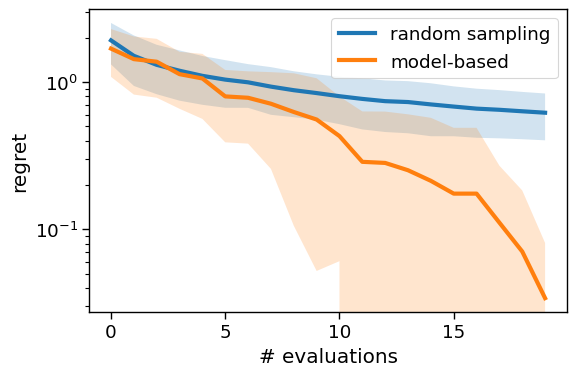

In [49]:
plt.figure(figsize=(6,4))
plt.plot(np.mean(regret_rand,axis=0), lw=3,label='random sampling')
plt.fill_between(
  np.arange(20),
  np.mean(regret_rand,axis=0)-np.std(regret_rand,axis=0),
  np.mean(regret_rand,axis=0)+np.std(regret_rand,axis=0),
  alpha=0.2
)
plt.plot(np.mean(regret_bo,axis=0), lw=3, label='model-based')
plt.fill_between(
  np.arange(20),
  np.mean(regret_bo,axis=0)-np.std(regret_bo,axis=0),
  np.mean(regret_bo,axis=0)+np.std(regret_bo,axis=0),
  alpha=0.2
)
plt.yscale('log')
plt.ylabel('regret')
plt.xlabel('# evaluations')
plt.legend()
plt.tight_layout()
# plt.savefig('synthetic_general_conditions_gradient.png', dpi=300)

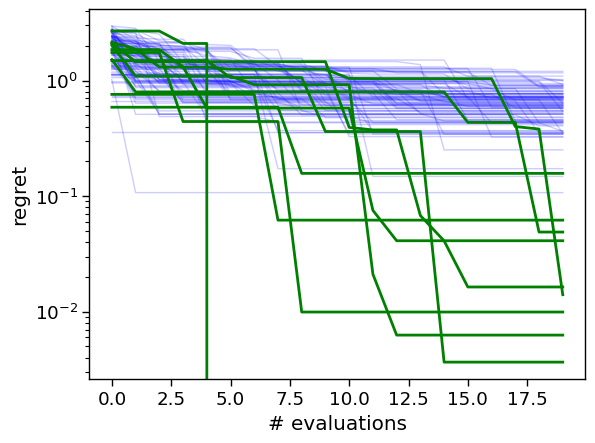

In [50]:
fig, ax = plt.subplots()

for r in regret_rand:
    ax.plot(r, lw=1, c='b', alpha=0.2)

for r in regret_bo:
    ax.plot(r, lw=2, c='g')

ax.set_yscale('log')
ax.set_ylabel('regret')
ax.set_xlabel('# evaluations')

plt.show()

## Multiobjective problem

In [9]:
# make parameter space
param_space = ParameterSpace()

# add ligand --> general parameter
param_space.add(
    ParameterCategorical(
        name='param_0',
        options=[str(i) for i in range(3)],
        descriptors=[None for i in range(3)],        # add descriptors later
    )
)
# add temperature
param_space.add(
    ParameterContinuous(
        name='param_1',
        low=0.,
        high=1.
    )
)
# add residence time
param_space.add(
    ParameterContinuous(
        name='param_2',
        low=0.,
        high=1.
    )
)
# add catalyst loading
# summit expects this to be in nM
param_space.add(
    ParameterContinuous(
        name='param_3',
        low=0.,
        high=1.,
    )
)


In [40]:
BUDGET = 25
NUM_RUNS = 15


#----------
# BayesOpt
#----------

wref = np.array([10000., 10000.])

all_campaigns = []
all_true_measurements = []
all_hvols = []

for run in range(NUM_RUNS):
    
    campaign = Campaign()
    campaign.set_param_space(param_space)
    
    value_space = ParameterSpace()
    value_space.add(ParameterContinuous(name='obj1'))
    value_space.add(ParameterContinuous(name='obj2'))

    planner = BoTorchPlanner(
        goal='minimize',
        init_design_strategy='random',
        num_init_design=5,
        batch_size=1,
        acquisition_optimizer_kind='gradient',
        general_parmeters=[0],
        is_moo=True,
        scalarizer_kind='Hypervolume', 
        value_space=value_space,
        goals=['min', 'min'],   
    )
    planner.set_param_space(param_space)

    true_measurements = []
    hvols = []

    for iter_ in range(BUDGET):

        samples = planner.recommend(campaign.observations)
        for sample in samples:
            measurement = moo_surface(
                [float(sample.param_1), float(sample.param_2), float(sample.param_3)],
                sample.param_0,
            )

            all_measurements = []
            for s in param_space[0].options:
                all_measurements.append(
                    moo_surface(
                        [float(sample.param_1), float(sample.param_2), float(sample.param_3)],
                        s,
                    )
                )
            true_measurements.append(np.mean(all_measurements, axis=0))
            
            hvol = get_hypervolume(np.array(true_measurements), wref)
            hvols.append(hvol)
            


        print(f'ITER : {iter_}\tSAMPLES : {samples}\t MEASUREMENT : {measurement}')
        campaign.add_observation(samples, measurement)
    
    all_true_measurements.append(true_measurements)
    all_hvols.append(hvols)
        
    all_campaigns.append(campaign)

[INFO] Generating 1 initial design points (batch 1/5)

ITER : 0	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9855353872581004, param_2 = 0.9381413127697222, param_3 = 0.288214449929846)]	 MEASUREMENT : [7.90020256 7.90020256]


[INFO] Generating 1 initial design points (batch 2/5)

ITER : 1	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8482777788725246, param_2 = 0.2364689625236589, param_3 = 0.8493292810065434)]	 MEASUREMENT : [2.9815099 2.9815099]


[INFO] Generating 1 initial design points (batch 3/5)

ITER : 2	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.04786919880654961, param_2 = 0.2279382802077674, param_3 = 0.6756672197788938)]	 MEASUREMENT : [11.66989641 11.66989641]


[INFO] Generating 1 initial design points (batch 4/5)

ITER : 3	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.6898913002732905, param_2 = 0.9291206197187748, param_3 = 0.3371391412585901)]	 MEASUREMENT : [3.93920175 3.93920175]


[INFO] Generating 1 initial design points (batch 5/5)

ITER : 4	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.35076867861256855, param_2 = 0.23812096578511988, param_3 = 0.7073209845078906)]	 MEASUREMENT : [11.93428262 11.93428262]


[INFO] Regression surrogate GP trained in 0.564 sec

ITER : 5	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9447067737592371, param_2 = 0.9941320389007392, param_3 = 0.5015256923723453)]	 MEASUREMENT : [2.68795576 2.68795576]


[INFO] Regression surrogate GP trained in 0.218 sec

ITER : 6	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9999999748810272, param_2 = 1.0, param_3 = 0.18285630434671754)]	 MEASUREMENT : [2.56325236 2.56325236]


[INFO] Regression surrogate GP trained in 0.697 sec

ITER : 7	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.7363778876668632, param_3 = 0.0)]	 MEASUREMENT : [0.00740906 0.00740906]


[INFO] Regression surrogate GP trained in 1.027 sec

ITER : 8	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9999999748810272, param_2 = 0.6510956868435441, param_3 = 0.0)]	 MEASUREMENT : [2.53236712 2.53236712]


[INFO] Regression surrogate GP trained in 0.617 sec

ITER : 9	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 1.0, param_3 = 0.0)]	 MEASUREMENT : [0.00540302 0.00540302]


[INFO] Regression surrogate GP trained in 0.7 sec

ITER : 10	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.11195765899527561, param_2 = 1.0, param_3 = 0.0)]	 MEASUREMENT : [0.34057477 0.34057477]


[INFO] Regression surrogate GP trained in 0.482 sec

ITER : 11	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 1.0, param_3 = 0.9999999857194055)]	 MEASUREMENT : [1.00540299 1.00540299]


[INFO] Regression surrogate GP trained in 0.528 sec

ITER : 12	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.0, param_3 = 0.0)]	 MEASUREMENT : [0.01 0.01]


[INFO] Regression surrogate GP trained in 0.184 sec

ITER : 13	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 1.0, param_3 = 0.0)]	 MEASUREMENT : [0.00540302 0.00540302]


[INFO] Regression surrogate GP trained in 0.114 sec

ITER : 14	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.5927562713623047, param_3 = 0.0)]	 MEASUREMENT : [0.00829404 0.00829404]


[INFO] Regression surrogate GP trained in 0.091 sec

ITER : 15	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.0, param_3 = 0.21775962101383642)]	 MEASUREMENT : [0.05741925 0.05741925]


[INFO] Regression surrogate GP trained in 0.155 sec

ITER : 16	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 1.0, param_3 = 0.0)]	 MEASUREMENT : [0.00540302 0.00540302]


[INFO] Regression surrogate GP trained in 0.08 sec

ITER : 17	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 1.0, param_3 = 0.09402561798528027)]	 MEASUREMENT : [0.01424384 0.01424384]


[INFO] Regression surrogate GP trained in 0.076 sec

ITER : 18	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.24900224804878235, param_3 = 0.0)]	 MEASUREMENT : [0.00969159 0.00969159]


[INFO] Regression surrogate GP trained in 0.099 sec

ITER : 19	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.0, param_2 = 0.0, param_3 = 0.0)]	 MEASUREMENT : [5.01 5.01]


[INFO] Regression surrogate GP trained in 0.1 sec

ITER : 20	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.9059898853302002, param_3 = 0.0)]	 MEASUREMENT : [0.00616907 0.00616907]


[INFO] Regression surrogate GP trained in 0.036 sec

ITER : 21	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.4268336296081543, param_3 = 0.09950058020119626)]	 MEASUREMENT : [0.01900318 0.01900318]


[INFO] Regression surrogate GP trained in 0.036 sec

ITER : 22	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.0, param_3 = 0.06512828823304195)]	 MEASUREMENT : [0.01424169 0.01424169]


[INFO] Regression surrogate GP trained in 0.037 sec

ITER : 23	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.9141838550567627, param_3 = 0.017451280478767858)]	 MEASUREMENT : [0.00640892 0.00640892]


[INFO] Regression surrogate GP trained in 0.036 sec

ITER : 24	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.050331520515022654, param_2 = 0.036231629550457, param_3 = 0.034847553321774166)]	 MEASUREMENT : [0.16213861 0.16213861]


[INFO] Generating 1 initial design points (batch 1/5)

ITER : 0	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.4948371168074428, param_2 = 0.9260495728605919, param_3 = 0.33704731505145447)]	 MEASUREMENT : [4.48281808 4.48281808]


[INFO] Generating 1 initial design points (batch 2/5)

ITER : 1	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.029378479736159147, param_2 = 0.6894920451842609, param_3 = 0.2762262018167779)]	 MEASUREMENT : [9.26058261 9.26058261]


[INFO] Generating 1 initial design points (batch 3/5)

ITER : 2	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8594543973150239, param_2 = 0.6877698736270583, param_3 = 0.0026777287049134513)]	 MEASUREMENT : [3.27198093 3.27198093]


[INFO] Generating 1 initial design points (batch 4/5)

ITER : 3	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.4489151683474145, param_2 = 0.9813237137950361, param_3 = 0.6489357210574223)]	 MEASUREMENT : [5.05670788 5.05670788]


[INFO] Generating 1 initial design points (batch 5/5)

ITER : 4	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.17238422785634222, param_2 = 0.9670409179719213, param_3 = 0.2231958392488953)]	 MEASUREMENT : [6.96206763 6.96206763]


[INFO] Regression surrogate GP trained in 0.709 sec

ITER : 5	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9999999715050193, param_2 = 0.03018750236881762, param_3 = 9.112569162791906e-11)]	 MEASUREMENT : [2.53440835 2.53440835]


[INFO] Regression surrogate GP trained in 0.608 sec

ITER : 6	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9999999715050193, param_2 = 0.9711043326648235, param_3 = 0.9999999723376011)]	 MEASUREMENT : [3.53005674 3.53005674]


[INFO] Regression surrogate GP trained in 1.596 sec

ITER : 7	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9999999715050193, param_2 = 1.0, param_3 = 0.0)]	 MEASUREMENT : [2.52981593 2.52981593]


[INFO] Regression surrogate GP trained in 0.449 sec

ITER : 8	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9259225514667005, param_2 = 0.6074498462467731, param_3 = 0.0016609606804937947)]	 MEASUREMENT : [2.40574076 2.40574076]


[INFO] Regression surrogate GP trained in 1.138 sec

ITER : 9	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8220506692829354, param_2 = 1.0, param_3 = 0.0)]	 MEASUREMENT : [2.20303293 2.20303293]


[INFO] Regression surrogate GP trained in 0.748 sec

ITER : 10	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7581141664746384, param_2 = 1.0, param_3 = 0.0)]	 MEASUREMENT : [2.06806293 2.06806293]


[INFO] Regression surrogate GP trained in 0.33 sec

ITER : 11	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.4279257660878253, param_2 = 1.0, param_3 = 0.0)]	 MEASUREMENT : [1.25035652 1.25035652]


[INFO] Regression surrogate GP trained in 0.409 sec

ITER : 12	SAMPLES : [ParamVector(param_0 = 1, param_1 = 8.809744253546192e-10, param_2 = 1.0, param_3 = 0.0)]	 MEASUREMENT : [0.00540303 0.00540303]


[INFO] Regression surrogate GP trained in 0.146 sec

ITER : 13	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 4.0819441923800603e-10, param_3 = 0.10759859979532356)]	 MEASUREMENT : [0.02157746 0.02157746]


[INFO] Regression surrogate GP trained in 0.1 sec

ITER : 14	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.0, param_3 = 0.0)]	 MEASUREMENT : [0.01 0.01]


[INFO] Regression surrogate GP trained in 0.025 sec

ITER : 15	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.36206525564193726, param_3 = 0.0)]	 MEASUREMENT : [0.00935167 0.00935167]


[INFO] Regression surrogate GP trained in 0.144 sec

ITER : 16	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 1.0, param_3 = 0.9999999723376011)]	 MEASUREMENT : [1.00540297 1.00540297]


[INFO] Regression surrogate GP trained in 0.279 sec

ITER : 17	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 1.0, param_3 = 0.0)]	 MEASUREMENT : [0.00540302 0.00540302]


[INFO] Regression surrogate GP trained in 0.311 sec

ITER : 18	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9999999715050193, param_2 = 0.0, param_3 = 0.9999999723376011)]	 MEASUREMENT : [12.74147097 12.74147097]


[INFO] Regression surrogate GP trained in 0.101 sec

ITER : 19	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.7534724473953247, param_3 = 0.0)]	 MEASUREMENT : [0.00729318 0.00729318]


[INFO] Regression surrogate GP trained in 0.105 sec

ITER : 20	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.0, param_3 = 0.9999999723376011)]	 MEASUREMENT : [1.00999994 1.00999994]


[INFO] Regression surrogate GP trained in 0.098 sec

ITER : 21	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.9035851955413818, param_3 = 0.0)]	 MEASUREMENT : [0.00618798 0.00618798]


[INFO] Regression surrogate GP trained in 0.108 sec

ITER : 22	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 1.0, param_3 = 0.09955174200524272)]	 MEASUREMENT : [0.01531357 0.01531357]


[INFO] Regression surrogate GP trained in 0.18 sec

ITER : 23	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 1.0, param_3 = 0.0)]	 MEASUREMENT : [0.00540302 0.00540302]


[INFO] Regression surrogate GP trained in 0.167 sec

ITER : 24	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9999999715050193, param_2 = 0.0, param_3 = 0.0)]	 MEASUREMENT : [12.84147097 12.84147097]


[INFO] Generating 1 initial design points (batch 1/5)

ITER : 0	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.15949290997431642, param_2 = 0.6902517045576648, param_3 = 0.18025909393491146)]	 MEASUREMENT : [9.39382092 9.39382092]


[INFO] Generating 1 initial design points (batch 2/5)

ITER : 1	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0989670364807842, param_2 = 0.827068657643166, param_3 = 0.7062106271381842)]	 MEASUREMENT : [8.15261634 8.15261634]


[INFO] Generating 1 initial design points (batch 3/5)

ITER : 2	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.09486024559701, param_2 = 0.6640671132324005, param_3 = 0.3325530461321321)]	 MEASUREMENT : [0.40262058 0.40262058]


[INFO] Generating 1 initial design points (batch 4/5)

ITER : 3	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.10968596574592848, param_2 = 0.1659901597626685, param_3 = 0.8310470061193379)]	 MEASUREMENT : [1.02890016 1.02890016]


[INFO] Generating 1 initial design points (batch 5/5)

ITER : 4	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5183872095999963, param_2 = 0.840300991186489, param_3 = 0.7122832226429316)]	 MEASUREMENT : [5.07251952 5.07251952]


[INFO] Regression surrogate GP trained in 0.168 sec

ITER : 5	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.12370652052839218, param_2 = 1.0, param_3 = 0.09217708097170263)]	 MEASUREMENT : [0.38407336 0.38407336]


[INFO] Regression surrogate GP trained in 0.345 sec

ITER : 6	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9475217125157505, param_2 = 0.8453841124695818, param_3 = 0.0012740686385669941)]	 MEASUREMENT : [2.44255035 2.44255035]


[INFO] Regression surrogate GP trained in 0.233 sec

ITER : 7	SAMPLES : [ParamVector(param_0 = 1, param_1 = 8.401795648094179e-10, param_2 = 0.9152819565600214, param_3 = 0.9999999944455336)]	 MEASUREMENT : [1.00609566 1.00609566]


[INFO] Regression surrogate GP trained in 0.915 sec

ITER : 8	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 1.0, param_3 = 0.10893642521365651)]	 MEASUREMENT : [0.01727017 0.01727017]


[INFO] Regression surrogate GP trained in 1.934 sec

ITER : 9	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 4.860956775987191e-09, param_3 = 0.0)]	 MEASUREMENT : [0.01 0.01]


[INFO] Regression surrogate GP trained in 0.576 sec

ITER : 10	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9999999705481356, param_2 = 0.0, param_3 = 0.9999999944455336)]	 MEASUREMENT : [12.74147097 12.74147097]


[INFO] Regression surrogate GP trained in 1.273 sec

ITER : 11	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 1.0, param_3 = 0.0)]	 MEASUREMENT : [0.00540302 0.00540302]


[INFO] Regression surrogate GP trained in 1.208 sec

ITER : 12	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.4307580165358613, param_2 = 0.07177723199129105, param_3 = 0.21590752779721648)]	 MEASUREMENT : [1.30926939 1.30926939]


[INFO] Regression surrogate GP trained in 0.573 sec

ITER : 13	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.5790409445762634, param_3 = 0.005209265247854976)]	 MEASUREMENT : [0.00839701 0.00839701]


[INFO] Regression surrogate GP trained in 0.228 sec

ITER : 14	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.0, param_3 = 0.09229976632587461)]	 MEASUREMENT : [0.01851925 0.01851925]


[INFO] Regression surrogate GP trained in 0.103 sec

ITER : 15	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.0, param_2 = 0.0, param_3 = 0.0)]	 MEASUREMENT : [5.01 5.01]


[INFO] Regression surrogate GP trained in 0.128 sec

ITER : 16	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9959666435642635, param_2 = 0.7898983359336853, param_3 = 0.022396750623755502)]	 MEASUREMENT : [2.72552092 2.72552092]


[INFO] Regression surrogate GP trained in 0.132 sec

ITER : 17	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9889648861487131, param_2 = 0.10346192121505737, param_3 = 0.8655350160206619)]	 MEASUREMENT : [4.05455388 4.05455388]


[INFO] Regression surrogate GP trained in 0.12 sec

ITER : 18	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9834324427882469, param_2 = 0.9371489882469177, param_3 = 0.9712910598210608)]	 MEASUREMENT : [3.44654047 3.44654047]


[INFO] Regression surrogate GP trained in 0.105 sec

ITER : 19	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9407165369494472, param_2 = 0.9061213731765747, param_3 = 0.022408876443609643)]	 MEASUREMENT : [8.2073794 8.2073794]


[INFO] Regression surrogate GP trained in 0.134 sec

ITER : 20	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7993613842141216, param_2 = 0.0018979664891958237, param_3 = 0.011529427889024621)]	 MEASUREMENT : [3.49582646 3.49582646]


[INFO] Regression surrogate GP trained in 0.32 sec

ITER : 21	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.004109558528326969, param_2 = 0.08633461594581604, param_3 = 0.331821499411944)]	 MEASUREMENT : [0.1323969 0.1323969]


[INFO] Regression surrogate GP trained in 0.142 sec

ITER : 22	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.009140272355592598, param_2 = 0.2638418972492218, param_3 = 0.11102250156724343)]	 MEASUREMENT : [0.04940038 0.04940038]


[INFO] Regression surrogate GP trained in 0.177 sec

ITER : 23	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.010105069429092409, param_2 = 0.24167244136333466, param_3 = 0.9985905830230032)]	 MEASUREMENT : [7.00100952 7.00100952]


[INFO] Regression surrogate GP trained in 0.185 sec

ITER : 24	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 1.0, param_3 = 0.0)]	 MEASUREMENT : [0.00540302 0.00540302]


[INFO] Generating 1 initial design points (batch 1/5)

ITER : 0	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.0036066941580940037, param_2 = 0.1617389085562897, param_3 = 0.3459943755417162)]	 MEASUREMENT : [5.0926764 5.0926764]


[INFO] Generating 1 initial design points (batch 2/5)

ITER : 1	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.4225207435234384, param_2 = 0.3773326656671614, param_3 = 0.6179066296976523)]	 MEASUREMENT : [5.04143155 5.04143155]


[INFO] Generating 1 initial design points (batch 3/5)

ITER : 2	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.7858769343002104, param_2 = 0.26106854573590843, param_3 = 0.5294252651876227)]	 MEASUREMENT : [12.24787941 12.24787941]


[INFO] Generating 1 initial design points (batch 4/5)

ITER : 3	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7481755976619002, param_2 = 0.21471102900287753, param_3 = 0.04596809845360694)]	 MEASUREMENT : [3.67462082 3.67462082]


[INFO] Generating 1 initial design points (batch 5/5)

ITER : 4	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.3959462740162556, param_2 = 0.15332619656738478, param_3 = 0.08567408092640771)]	 MEASUREMENT : [4.62430048 4.62430048]


[INFO] Regression surrogate GP trained in 0.526 sec

ITER : 5	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9999999647836372, param_2 = 0.2144549083573593, param_3 = 1.4462846198437518e-10)]	 MEASUREMENT : [2.7112826 2.7112826]


[INFO] Regression surrogate GP trained in 0.661 sec

ITER : 6	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5233285203610301, param_2 = 0.8462030787699049, param_3 = 0.7474997631374231)]	 MEASUREMENT : [2.06468201 2.06468201]


[INFO] Regression surrogate GP trained in 0.688 sec

ITER : 7	SAMPLES : [ParamVector(param_0 = 1, param_1 = 5.049962661582419e-11, param_2 = 3.1756269280869276e-09, param_3 = 1.3091548447980953e-18)]	 MEASUREMENT : [0.01 0.01]


[INFO] Regression surrogate GP trained in 0.537 sec

ITER : 8	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9999999647836372, param_2 = 0.0, param_3 = 0.0)]	 MEASUREMENT : [2.5344129 2.5344129]


[INFO] Regression surrogate GP trained in 0.5 sec

ITER : 9	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.0, param_3 = 1.0)]	 MEASUREMENT : [1.01 1.01]


[INFO] Regression surrogate GP trained in 0.605 sec

ITER : 10	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 1.0, param_3 = 0.0)]	 MEASUREMENT : [0.00540302 0.00540302]


[INFO] Regression surrogate GP trained in 1.385 sec

ITER : 11	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 1.0, param_3 = 0.0)]	 MEASUREMENT : [0.00540302 0.00540302]


[INFO] Regression surrogate GP trained in 0.387 sec

ITER : 12	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 1.0, param_3 = 0.0)]	 MEASUREMENT : [0.00540302 0.00540302]


[INFO] Regression surrogate GP trained in 0.398 sec

ITER : 13	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 1.0, param_3 = 0.0)]	 MEASUREMENT : [0.00540302 0.00540302]


[INFO] Regression surrogate GP trained in 0.699 sec

ITER : 14	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 1.0, param_3 = 0.0)]	 MEASUREMENT : [0.00540302 0.00540302]


[INFO] Regression surrogate GP trained in 1.429 sec

ITER : 15	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 1.0, param_3 = 0.0)]	 MEASUREMENT : [0.00540302 0.00540302]


[INFO] Regression surrogate GP trained in 0.53 sec

ITER : 16	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 1.0, param_3 = 0.0)]	 MEASUREMENT : [0.00540302 0.00540302]


[INFO] Regression surrogate GP trained in 0.602 sec

ITER : 17	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 1.0, param_3 = 0.0)]	 MEASUREMENT : [0.00540302 0.00540302]


[INFO] Regression surrogate GP trained in 0.951 sec

ITER : 18	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.09524544738089381, param_2 = 0.5404857993125916, param_3 = 0.0)]	 MEASUREMENT : [0.29387911 0.29387911]


[INFO] Regression surrogate GP trained in 0.415 sec

ITER : 19	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.31841394305229187, param_3 = 0.12039832770824432)]	 MEASUREMENT : [0.02399309 0.02399309]


[INFO] Regression surrogate GP trained in 0.778 sec

ITER : 20	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 1.0, param_3 = 0.01774374395608902)]	 MEASUREMENT : [0.00571786 0.00571786]


[INFO] Regression surrogate GP trained in 0.121 sec

ITER : 21	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.5000509023666382, param_3 = 0.0)]	 MEASUREMENT : [0.00877558 0.00877558]


[INFO] Regression surrogate GP trained in 0.184 sec

ITER : 22	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 1.0, param_3 = 0.09570828080177307)]	 MEASUREMENT : [0.0145631 0.0145631]


[INFO] Regression surrogate GP trained in 0.195 sec

ITER : 23	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0, param_2 = 1.0, param_3 = 0.0)]	 MEASUREMENT : [6.48362767 6.48362767]


[INFO] Regression surrogate GP trained in 0.02 sec

ITER : 24	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.22086937725543976, param_3 = 0.0)]	 MEASUREMENT : [0.00975707 0.00975707]


[INFO] Generating 1 initial design points (batch 1/5)

ITER : 0	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6280954911525118, param_2 = 0.03747260255101359, param_3 = 0.5989023611593111)]	 MEASUREMENT : [2.1314914 2.1314914]


[INFO] Generating 1 initial design points (batch 2/5)

ITER : 1	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.567200767401366, param_2 = 0.27610268083058254, param_3 = 0.18429516575707527)]	 MEASUREMENT : [4.23918147 4.23918147]


[INFO] Generating 1 initial design points (batch 3/5)

ITER : 2	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.3824460273927782, param_2 = 0.10228395217999331, param_3 = 0.4711300164817491)]	 MEASUREMENT : [12.26336056 12.26336056]


[INFO] Generating 1 initial design points (batch 4/5)

ITER : 3	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8248383739757259, param_2 = 0.19421789480595775, param_3 = 0.45835576424271507)]	 MEASUREMENT : [12.46298951 12.46298951]


[INFO] Generating 1 initial design points (batch 5/5)

ITER : 4	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.6224845484724937, param_2 = 0.9379354753231657, param_3 = 0.12258559255123747)]	 MEASUREMENT : [7.66824481 7.66824481]


[INFO] Regression surrogate GP trained in 0.133 sec

ITER : 5	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8285679542291298, param_2 = 0.7561054489754935, param_3 = 0.15292446426205933)]	 MEASUREMENT : [2.24155351 2.24155351]


[INFO] Regression surrogate GP trained in 0.433 sec

ITER : 6	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8187302109000854, param_2 = 0.13076085390898357, param_3 = 0.6876030588412734)]	 MEASUREMENT : [2.67354949 2.67354949]


[INFO] Regression surrogate GP trained in 0.192 sec

ITER : 7	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.1394309574579273, param_2 = 0.0442276589403008, param_3 = 0.41165123243315416)]	 MEASUREMENT : [0.59638581 0.59638581]


[INFO] Regression surrogate GP trained in 0.411 sec

ITER : 8	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.9940614403278799, param_3 = 1.966998508518003e-09)]	 MEASUREMENT : [0.0054529 0.0054529]


[INFO] Regression surrogate GP trained in 1.463 sec

ITER : 9	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 1.0, param_3 = 1.0)]	 MEASUREMENT : [1.00540302 1.00540302]


[INFO] Regression surrogate GP trained in 1.309 sec

ITER : 10	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.0, param_3 = 0.0)]	 MEASUREMENT : [0.01 0.01]


[INFO] Regression surrogate GP trained in 1.082 sec

ITER : 11	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 1.0, param_3 = 0.08378023654222488)]	 MEASUREMENT : [0.01242215 0.01242215]


[INFO] Regression surrogate GP trained in 1.191 sec

ITER : 12	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.0, param_2 = 1.0, param_3 = 1.0)]	 MEASUREMENT : [7.00540302 7.00540302]


[INFO] Regression surrogate GP trained in 0.977 sec

ITER : 13	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.004753853297348644, param_2 = 0.26201000809669495, param_3 = 0.07004288583993912)]	 MEASUREMENT : [0.02882622 0.02882622]


[INFO] Regression surrogate GP trained in 0.416 sec

ITER : 14	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.5837281346321106, param_3 = 0.0)]	 MEASUREMENT : [0.00834414 0.00834414]


[INFO] Regression surrogate GP trained in 0.179 sec

ITER : 15	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.0, param_3 = 0.0)]	 MEASUREMENT : [0.01 0.01]


[INFO] Regression surrogate GP trained in 0.208 sec

ITER : 16	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9930337853109288, param_2 = 0.5825952291488647, param_3 = 0.9875809550285339)]	 MEASUREMENT : [4.66551275 4.66551275]


[INFO] Regression surrogate GP trained in 0.16 sec

ITER : 17	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0053824505697004504, param_2 = 0.8719179034233093, param_3 = 0.030614905059337616)]	 MEASUREMENT : [0.02351814 0.02351814]


[INFO] Regression surrogate GP trained in 0.12 sec

ITER : 18	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.2654854953289032, param_3 = 0.0)]	 MEASUREMENT : [0.00964965 0.00964965]


[INFO] Regression surrogate GP trained in 0.071 sec

ITER : 19	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 1.0, param_3 = 0.0)]	 MEASUREMENT : [0.00540302 0.00540302]


[INFO] Regression surrogate GP trained in 0.146 sec

ITER : 20	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9440844851261171, param_2 = 0.9100327491760254, param_3 = 0.04639989137649536)]	 MEASUREMENT : [2.93876027 2.93876027]


[INFO] Regression surrogate GP trained in 0.074 sec

ITER : 21	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.0, param_3 = 0.12552054226398468)]	 MEASUREMENT : [0.02575541 0.02575541]


[INFO] Regression surrogate GP trained in 0.148 sec

ITER : 22	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.29079073667526245, param_3 = 8.045590322572923e-20)]	 MEASUREMENT : [0.00958017 0.00958017]


[INFO] Regression surrogate GP trained in 0.093 sec

ITER : 23	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.24326556668759616, param_2 = 0.8969885110855103, param_3 = 0.022370386868715286)]	 MEASUREMENT : [0.72936006 0.72936006]


[INFO] Regression surrogate GP trained in 0.141 sec

ITER : 24	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.011095890259393426, param_2 = 0.939584493637085, param_3 = 0.25972044467926025)]	 MEASUREMENT : [0.10664293 0.10664293]


[INFO] Generating 1 initial design points (batch 1/5)

ITER : 0	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.8207744051324339, param_2 = 0.2031906745901918, param_3 = 0.4369758458390476)]	 MEASUREMENT : [12.44110875 12.44110875]


[INFO] Generating 1 initial design points (batch 2/5)

ITER : 1	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.16845510682591136, param_2 = 0.9182598635654011, param_3 = 0.7927010649456028)]	 MEASUREMENT : [7.37483375 7.37483375]


[INFO] Generating 1 initial design points (batch 3/5)

ITER : 2	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.10928851491643266, param_2 = 0.9095771579795116, param_3 = 0.6019744886655252)]	 MEASUREMENT : [0.69572734 0.69572734]


[INFO] Generating 1 initial design points (batch 4/5)

ITER : 3	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.573509008139239, param_2 = 0.6509427024351808, param_3 = 0.0845347700912773)]	 MEASUREMENT : [10.08028469 10.08028469]


[INFO] Generating 1 initial design points (batch 5/5)

ITER : 4	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.13398603636989048, param_2 = 0.43714959855453317, param_3 = 0.35532760073634617)]	 MEASUREMENT : [10.96959776 10.96959776]


[INFO] Regression surrogate GP trained in 0.911 sec

ITER : 5	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9966817998847618, param_2 = 1.0, param_3 = 1.0)]	 MEASUREMENT : [4.7208605 4.7208605]


[INFO] Regression surrogate GP trained in 0.638 sec

ITER : 6	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.718833637625718, param_2 = 1.0, param_3 = 1.0)]	 MEASUREMENT : [2.98092506 2.98092506]


[INFO] Regression surrogate GP trained in 0.347 sec

ITER : 7	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.14200572475499357, param_3 = 0.9931833449693711)]	 MEASUREMENT : [0.9963125 0.9963125]


[INFO] Regression surrogate GP trained in 0.606 sec

ITER : 8	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.9217696957137338, param_3 = 0.854350303990748)]	 MEASUREMENT : [0.73595855 0.73595855]


[INFO] Regression surrogate GP trained in 0.387 sec

ITER : 9	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.089073293903532, param_2 = 0.6385162263605526, param_3 = 0.042807138790539566)]	 MEASUREMENT : [4.98836468 4.98836468]


[INFO] Regression surrogate GP trained in 1.449 sec

ITER : 10	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.06884396439559046, param_2 = 1.0, param_3 = 0.10070511147114335)]	 MEASUREMENT : [0.22191333 0.22191333]


[INFO] Regression surrogate GP trained in 0.391 sec

ITER : 11	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.7462542088489974, param_3 = 0.0)]	 MEASUREMENT : [0.00734237 0.00734237]


[INFO] Regression surrogate GP trained in 0.595 sec

ITER : 12	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 1.0330648003709086e-09, param_3 = 0.0)]	 MEASUREMENT : [0.01 0.01]


[INFO] Regression surrogate GP trained in 0.153 sec

ITER : 13	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.3777332312336622, param_3 = 0.0)]	 MEASUREMENT : [0.00929503 0.00929503]


[INFO] Regression surrogate GP trained in 0.222 sec

ITER : 14	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 1.0, param_3 = 0.0)]	 MEASUREMENT : [0.00540302 0.00540302]


[INFO] Regression surrogate GP trained in 0.077 sec

ITER : 15	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 1.0, param_3 = 0.0)]	 MEASUREMENT : [0.00540302 0.00540302]


[INFO] Regression surrogate GP trained in 0.082 sec

ITER : 16	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 1.0, param_3 = 0.0)]	 MEASUREMENT : [0.00540302 0.00540302]


[INFO] Regression surrogate GP trained in 0.123 sec

ITER : 17	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9518210030890373, param_2 = 0.2090975799386431, param_3 = 0.01577191799879074)]	 MEASUREMENT : [2.45345115 2.45345115]


[INFO] Regression surrogate GP trained in 0.078 sec

ITER : 18	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 1.0, param_3 = 0.0)]	 MEASUREMENT : [0.00540302 0.00540302]


[INFO] Regression surrogate GP trained in 0.074 sec

ITER : 19	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.1704943301664068, param_2 = 0.0, param_3 = 0.0)]	 MEASUREMENT : [0.5190086 0.5190086]


[INFO] Regression surrogate GP trained in 0.172 sec

ITER : 20	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.0, param_3 = 0.0)]	 MEASUREMENT : [0.01 0.01]


[INFO] Regression surrogate GP trained in 0.26 sec

ITER : 21	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.13975311815738678, param_3 = 0.08859166502952576)]	 MEASUREMENT : [0.01775099 0.01775099]


[INFO] Regression surrogate GP trained in 0.134 sec

ITER : 22	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 1.0, param_3 = 0.057652685791254044)]	 MEASUREMENT : [0.00872686 0.00872686]


[INFO] Regression surrogate GP trained in 0.183 sec

ITER : 23	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 1.0, param_3 = 0.0)]	 MEASUREMENT : [0.00540302 0.00540302]


[INFO] Regression surrogate GP trained in 0.128 sec

ITER : 24	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9466671011406567, param_2 = 0.03473567217588425, param_3 = 0.010027971118688583)]	 MEASUREMENT : [2.93195041 2.93195041]


[INFO] Generating 1 initial design points (batch 1/5)

ITER : 0	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.23938231482999073, param_2 = 0.5126694122877083, param_3 = 0.11925980266021474)]	 MEASUREMENT : [10.68243566 10.68243566]


[INFO] Generating 1 initial design points (batch 2/5)

ITER : 1	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.7259750692048235, param_2 = 0.6588610891458072, param_3 = 0.5179963312852168)]	 MEASUREMENT : [4.02514697 4.02514697]


[INFO] Generating 1 initial design points (batch 3/5)

ITER : 2	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.37494080394859597, param_2 = 0.7958656940137652, param_3 = 0.42538001365326783)]	 MEASUREMENT : [4.81358663 4.81358663]


[INFO] Generating 1 initial design points (batch 4/5)

ITER : 3	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.17183745551028873, param_2 = 0.34912985914076633, param_3 = 0.49614745135383265)]	 MEASUREMENT : [0.76853809 0.76853809]


[INFO] Generating 1 initial design points (batch 5/5)

ITER : 4	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.4082434925627022, param_2 = 0.5472345393172524, param_3 = 0.038871211715188037)]	 MEASUREMENT : [4.59775497 4.59775497]


[INFO] Regression surrogate GP trained in 0.193 sec

ITER : 5	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9309799619237461, param_2 = 0.9969366757946353, param_3 = 0.10769344909666365)]	 MEASUREMENT : [2.42364288 2.42364288]


[INFO] Regression surrogate GP trained in 0.661 sec

ITER : 6	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.0, param_3 = 0.9999999913444532)]	 MEASUREMENT : [1.00999998 1.00999998]


[INFO] Regression surrogate GP trained in 0.157 sec

ITER : 7	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.1852630156443999, param_2 = 1.0, param_3 = 1.729271385808584e-09)]	 MEASUREMENT : [0.55801819 0.55801819]


[INFO] Regression surrogate GP trained in 0.305 sec

ITER : 8	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.14435074092301037, param_2 = 1.0, param_3 = 0.9999999913444532)]	 MEASUREMENT : [1.43695287 1.43695287]


[INFO] Regression surrogate GP trained in 0.31 sec

ITER : 9	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.0, param_3 = 1.1019275156391736e-17)]	 MEASUREMENT : [0.01 0.01]


[INFO] Regression surrogate GP trained in 0.47 sec

ITER : 10	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.6894015669822693, param_3 = 3.0217300334456138e-25)]	 MEASUREMENT : [0.00771627 0.00771627]


[INFO] Regression surrogate GP trained in 0.439 sec

ITER : 11	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 1.0, param_3 = 0.09613748556609755)]	 MEASUREMENT : [0.01464544 0.01464544]


[INFO] Regression surrogate GP trained in 0.791 sec

ITER : 12	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9944013159864203, param_2 = 0.9938172101974487, param_3 = 0.9967611941846816)]	 MEASUREMENT : [3.51428632 3.51428632]


[INFO] Regression surrogate GP trained in 0.377 sec

ITER : 13	SAMPLES : [ParamVector(param_0 = 0, param_1 = 1.0, param_2 = 0.0, param_3 = 0.9999999913444532)]	 MEASUREMENT : [12.74147099 12.74147099]


[INFO] Regression surrogate GP trained in 0.277 sec

ITER : 14	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0007970212027430534, param_2 = 0.8174837231636047, param_3 = 0.13319077972522797)]	 MEASUREMENT : [0.02697144 0.02697144]


[INFO] Regression surrogate GP trained in 0.528 sec

ITER : 15	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.008368258364498615, param_2 = 0.3665412962436676, param_3 = 0.09976091894585612)]	 MEASUREMENT : [0.04439245 0.04439245]


[INFO] Regression surrogate GP trained in 0.172 sec

ITER : 16	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.008540088310837746, param_2 = 0.014119059778749943, param_3 = 0.13264563564883078)]	 MEASUREMENT : [0.05321382 0.05321382]


[INFO] Regression surrogate GP trained in 0.152 sec

ITER : 17	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.039569124579429626, param_2 = 0.10300268232822418, param_3 = 0.9689866220526492)]	 MEASUREMENT : [11.87905908 11.87905908]


[INFO] Regression surrogate GP trained in 0.158 sec

ITER : 18	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.004058952443301678, param_2 = 0.7102916836738586, param_3 = 0.3685580460118939)]	 MEASUREMENT : [0.15559357 0.15559357]


[INFO] Regression surrogate GP trained in 0.158 sec

ITER : 19	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9776739478111267, param_2 = 0.06555648148059845, param_3 = 0.9959788832287759)]	 MEASUREMENT : [4.7807128 4.7807128]


[INFO] Regression surrogate GP trained in 0.158 sec

ITER : 20	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9945324063301086, param_2 = 0.7880116105079651, param_3 = 0.05696264605093679)]	 MEASUREMENT : [2.73189736 2.73189736]


[INFO] Regression surrogate GP trained in 0.154 sec

ITER : 21	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0008557448163628578, param_2 = 0.9922908544540405, param_3 = 0.15349541471660214)]	 MEASUREMENT : [0.03159581 0.03159581]


[INFO] Regression surrogate GP trained in 0.088 sec

ITER : 22	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.9521430134773254, param_3 = 8.778448364895844e-33)]	 MEASUREMENT : [0.00579939 0.00579939]


[INFO] Regression surrogate GP trained in 0.108 sec

ITER : 23	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.17567361891269684, param_3 = 0.0)]	 MEASUREMENT : [0.00984609 0.00984609]


[INFO] Regression surrogate GP trained in 0.033 sec

ITER : 24	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 1.0, param_3 = 0.0)]	 MEASUREMENT : [0.00540302 0.00540302]


[INFO] Generating 1 initial design points (batch 1/5)

ITER : 0	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.42989692516069666, param_2 = 0.7766612525075178, param_3 = 0.8737972121029529)]	 MEASUREMENT : [5.88650218 5.88650218]


[INFO] Generating 1 initial design points (batch 2/5)

ITER : 1	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.7939609454222379, param_2 = 0.2266277048997395, param_3 = 0.7170838367318877)]	 MEASUREMENT : [12.33458318 12.33458318]


[INFO] Generating 1 initial design points (batch 3/5)

ITER : 2	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.3404729829374985, param_2 = 0.4034374881451652, param_3 = 0.6418308457643718)]	 MEASUREMENT : [1.42294289 1.42294289]


[INFO] Generating 1 initial design points (batch 4/5)

ITER : 3	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9107435415282498, param_2 = 0.3118688140929583, param_3 = 0.8625811715020681)]	 MEASUREMENT : [12.12484346 12.12484346]


[INFO] Generating 1 initial design points (batch 5/5)

ITER : 4	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.2599997277340238, param_2 = 0.7495338744257194, param_3 = 0.25467708934567257)]	 MEASUREMENT : [0.84342135 0.84342135]


[INFO] Regression surrogate GP trained in 0.55 sec

ITER : 5	SAMPLES : [ParamVector(param_0 = 1, param_1 = 7.640542698528208e-09, param_2 = 0.9999999957713126, param_3 = 8.345315216651272e-09)]	 MEASUREMENT : [0.00540305 0.00540305]


[INFO] Regression surrogate GP trained in 0.789 sec

ITER : 6	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.9999999957713126, param_3 = 0.99999998667049)]	 MEASUREMENT : [1.005403 1.005403]


[INFO] Regression surrogate GP trained in 0.704 sec

ITER : 7	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.0, param_3 = 0.0)]	 MEASUREMENT : [0.01 0.01]


[INFO] Regression surrogate GP trained in 0.654 sec

ITER : 8	SAMPLES : [ParamVector(param_0 = 1, param_1 = 1.0, param_2 = 0.9999999957713126, param_3 = 0.0)]	 MEASUREMENT : [2.52981598 2.52981598]


[INFO] Regression surrogate GP trained in 0.45 sec

ITER : 9	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.9999999957713126, param_3 = 0.117898745753411)]	 MEASUREMENT : [0.01930314 0.01930314]


[INFO] Regression surrogate GP trained in 0.533 sec

ITER : 10	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.9999999957713126, param_3 = 0.022539511022534518)]	 MEASUREMENT : [0.00591105 0.00591105]


[INFO] Regression surrogate GP trained in 0.084 sec

ITER : 11	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.5160482504003433, param_3 = 0.0)]	 MEASUREMENT : [0.00869776 0.00869776]


[INFO] Regression surrogate GP trained in 0.044 sec

ITER : 12	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.0, param_3 = 0.4427175760861725)]	 MEASUREMENT : [0.20599885 0.20599885]


[INFO] Regression surrogate GP trained in 0.293 sec

ITER : 13	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.013917827978730202, param_2 = 0.087794839964589, param_3 = 0.032433658405947315)]	 MEASUREMENT : [5.00954546 5.00954546]


[INFO] Regression surrogate GP trained in 0.247 sec

ITER : 14	SAMPLES : [ParamVector(param_0 = 2, param_1 = 1.0, param_2 = 0.0, param_3 = 0.0)]	 MEASUREMENT : [2.71151153 2.71151153]


[INFO] Regression surrogate GP trained in 0.149 sec

ITER : 15	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.8032783235914073, param_3 = 0.0)]	 MEASUREMENT : [0.00694351 0.00694351]


[INFO] Regression surrogate GP trained in 0.28 sec

ITER : 16	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.022826846688985825, param_2 = 0.8985637984425336, param_3 = 0.9802164900775048)]	 MEASUREMENT : [7.39761532 7.39761532]


[INFO] Regression surrogate GP trained in 0.027 sec

ITER : 17	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.21672822443390402, param_3 = 0.0)]	 MEASUREMENT : [0.00976606 0.00976606]


[INFO] Regression surrogate GP trained in 0.033 sec

ITER : 18	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.4586425404227572, param_3 = 0.13773952240926177)]	 MEASUREMENT : [0.02793872 0.02793872]


[INFO] Regression surrogate GP trained in 0.158 sec

ITER : 19	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.9999999957713126, param_3 = 0.0)]	 MEASUREMENT : [0.00540302 0.00540302]


[INFO] Regression surrogate GP trained in 0.03 sec

ITER : 20	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.11856520920991898, param_2 = 0.0, param_3 = 0.0)]	 MEASUREMENT : [0.36486284 0.36486284]


[INFO] Regression surrogate GP trained in 0.031 sec

ITER : 21	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.9198090395178553, param_3 = 0.009756163563919599)]	 MEASUREMENT : [0.0061549 0.0061549]


[INFO] Regression surrogate GP trained in 0.039 sec

ITER : 22	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.9999999957713126, param_3 = 0.0)]	 MEASUREMENT : [0.00540302 0.00540302]


[INFO] Regression surrogate GP trained in 0.033 sec

ITER : 23	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.7070173591280119, param_3 = 0.04141328056089057)]	 MEASUREMENT : [0.00931809 0.00931809]


[INFO] Regression surrogate GP trained in 0.103 sec

ITER : 24	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.9999999957713126, param_3 = 0.0)]	 MEASUREMENT : [0.00540302 0.00540302]


[INFO] Generating 1 initial design points (batch 1/5)

ITER : 0	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6541100803760201, param_2 = 0.09674086922140679, param_3 = 0.03812938175827896)]	 MEASUREMENT : [1.83676685 1.83676685]


[INFO] Generating 1 initial design points (batch 2/5)

ITER : 1	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.47376020696834575, param_2 = 0.03880987177574036, param_3 = 0.46716023604039925)]	 MEASUREMENT : [1.59693783 1.59693783]


[INFO] Generating 1 initial design points (batch 3/5)

ITER : 2	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6760969756798658, param_2 = 0.0589727148851702, param_3 = 0.9305613655370667)]	 MEASUREMENT : [2.75318714 2.75318714]


[INFO] Generating 1 initial design points (batch 4/5)

ITER : 3	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0640431277866047, param_2 = 0.5675267906635691, param_3 = 0.8761417649056845)]	 MEASUREMENT : [0.9680548 0.9680548]


[INFO] Generating 1 initial design points (batch 5/5)

ITER : 4	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.5893589957883616, param_2 = 0.41129273196822214, param_3 = 0.4412140169369574)]	 MEASUREMENT : [1.87132067 1.87132067]


[INFO] Regression surrogate GP trained in 1.398 sec

ITER : 5	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.0, param_2 = 0.0, param_3 = 0.0)]	 MEASUREMENT : [12. 12.]


[INFO] Regression surrogate GP trained in 1.23 sec

ITER : 6	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.9999999782479178, param_3 = 0.0)]	 MEASUREMENT : [0.00540302 0.00540302]


[INFO] Regression surrogate GP trained in 0.695 sec

ITER : 7	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.06341373606881326, param_2 = 0.9274877704097735, param_3 = 0.059890187810872124)]	 MEASUREMENT : [4.99637821 4.99637821]


[INFO] Regression surrogate GP trained in 0.167 sec

ITER : 8	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.0, param_3 = 0.0)]	 MEASUREMENT : [0.01 0.01]


[INFO] Regression surrogate GP trained in 0.309 sec

ITER : 9	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.9999999782479178, param_3 = 0.11551318519778551)]	 MEASUREMENT : [0.01874632 0.01874632]


[INFO] Regression surrogate GP trained in 0.452 sec

ITER : 10	SAMPLES : [ParamVector(param_0 = 2, param_1 = 1.0, param_2 = 0.0, param_3 = 0.9999999734455799)]	 MEASUREMENT : [4.71151137 4.71151137]


[INFO] Regression surrogate GP trained in 0.57 sec

ITER : 11	SAMPLES : [ParamVector(param_0 = 0, param_1 = 1.0, param_2 = 0.9999999782479178, param_3 = 0.9999999734455799)]	 MEASUREMENT : [7.22509888 7.22509888]


[INFO] Regression surrogate GP trained in 0.796 sec

ITER : 12	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.01520219910889864, param_2 = 0.8532288484944811, param_3 = 0.020746336698968113)]	 MEASUREMENT : [0.05261079 0.05261079]


[INFO] Regression surrogate GP trained in 0.149 sec

ITER : 13	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.0, param_3 = 0.10071471066061642)]	 MEASUREMENT : [0.02014345 0.02014345]


[INFO] Regression surrogate GP trained in 0.151 sec

ITER : 14	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.00029148434987291694, param_2 = 0.20325089548979652, param_3 = 0.1367064380106936)]	 MEASUREMENT : [0.02935726 0.02935726]


[INFO] Regression surrogate GP trained in 0.178 sec

ITER : 15	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.990360677242279, param_2 = 0.9515872986750789, param_3 = 0.004607412841758427)]	 MEASUREMENT : [2.74774555 2.74774555]


[INFO] Regression surrogate GP trained in 0.211 sec

ITER : 16	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9545872807502747, param_2 = 0.44635899884140606, param_3 = 0.0019678119047475805)]	 MEASUREMENT : [11.64017658 11.64017658]


[INFO] Regression surrogate GP trained in 0.133 sec

ITER : 17	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.922510027885437, param_2 = 0.03730764158874583, param_3 = 0.019849452594333003)]	 MEASUREMENT : [3.02911502 3.02911502]


[INFO] Regression surrogate GP trained in 0.142 sec

ITER : 18	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.005781465210020542, param_2 = 0.10852733018363132, param_3 = 0.3064424314187206)]	 MEASUREMENT : [0.12119243 0.12119243]


[INFO] Regression surrogate GP trained in 0.193 sec

ITER : 19	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.004833824932575226, param_2 = 0.1379339664973296, param_3 = 0.9981912705478997)]	 MEASUREMENT : [11.79104088 11.79104088]


[INFO] Regression surrogate GP trained in 0.205 sec

ITER : 20	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.006081194616854191, param_2 = 0.4942044210222566, param_3 = 0.052522643005888256)]	 MEASUREMENT : [0.02980556 0.02980556]


[INFO] Regression surrogate GP trained in 0.091 sec

ITER : 21	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.7585807873704428, param_3 = 0.0)]	 MEASUREMENT : [0.00725813 0.00725813]


[INFO] Regression surrogate GP trained in 0.093 sec

ITER : 22	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.9999999782479178, param_3 = 0.0)]	 MEASUREMENT : [0.00540302 0.00540302]


[INFO] Regression surrogate GP trained in 0.09 sec

ITER : 23	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.30192657648414967, param_3 = 0.0)]	 MEASUREMENT : [0.00954765 0.00954765]


[INFO] Regression surrogate GP trained in 0.097 sec

ITER : 24	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.9999999782479178, param_3 = 0.0)]	 MEASUREMENT : [0.00540302 0.00540302]


[INFO] Generating 1 initial design points (batch 1/5)

ITER : 0	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9929032204557676, param_2 = 0.8482648914647364, param_3 = 0.256027038443857)]	 MEASUREMENT : [8.74744117 8.74744117]


[INFO] Generating 1 initial design points (batch 2/5)

ITER : 1	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.42558810610421893, param_2 = 0.281237873313952, param_3 = 0.27052043746687027)]	 MEASUREMENT : [11.91435576 11.91435576]


[INFO] Generating 1 initial design points (batch 3/5)

ITER : 2	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6078461990190501, param_2 = 0.08973164409377243, param_3 = 0.6436906604385877)]	 MEASUREMENT : [2.13759976 2.13759976]


[INFO] Generating 1 initial design points (batch 4/5)

ITER : 3	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.019149140659267316, param_2 = 0.8989519135893853, param_3 = 0.15373057155940162)]	 MEASUREMENT : [0.08730131 0.08730131]


[INFO] Generating 1 initial design points (batch 5/5)

ITER : 4	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.11740198632957555, param_2 = 0.18850581403743216, param_3 = 0.727286651999802)]	 MEASUREMENT : [5.7447949 5.7447949]


[INFO] Regression surrogate GP trained in 0.509 sec

ITER : 5	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8968810561026468, param_2 = 0.9999999739773267, param_3 = 4.433740596887503e-10)]	 MEASUREMENT : [2.34955603 2.34955603]


[INFO] Regression surrogate GP trained in 0.28 sec

ITER : 6	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.0506549611090262, param_3 = 0.6452246137659701)]	 MEASUREMENT : [0.42630198 0.42630198]


[INFO] Regression surrogate GP trained in 1.067 sec

ITER : 7	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.9999999739773267, param_3 = 0.0)]	 MEASUREMENT : [0.00540302 0.00540302]


[INFO] Regression surrogate GP trained in 0.912 sec

ITER : 8	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.9999999739773267, param_3 = 0.9999999859488841)]	 MEASUREMENT : [1.005403 1.005403]


[INFO] Regression surrogate GP trained in 0.801 sec

ITER : 9	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 1.104639615889802e-09, param_3 = 0.0)]	 MEASUREMENT : [0.01 0.01]


[INFO] Regression surrogate GP trained in 0.786 sec

ITER : 10	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.9999999739773267, param_3 = 0.0)]	 MEASUREMENT : [0.00540302 0.00540302]


[INFO] Regression surrogate GP trained in 0.777 sec

ITER : 11	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.9999999739773267, param_3 = 0.0)]	 MEASUREMENT : [0.00540302 0.00540302]


[INFO] Regression surrogate GP trained in 0.499 sec

ITER : 12	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.9999999739773267, param_3 = 0.0)]	 MEASUREMENT : [0.00540302 0.00540302]


[INFO] Regression surrogate GP trained in 1.591 sec

ITER : 13	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.9999999739773267, param_3 = 0.0)]	 MEASUREMENT : [0.00540302 0.00540302]


[INFO] Regression surrogate GP trained in 0.367 sec

ITER : 14	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.9999999739773267, param_3 = 0.0)]	 MEASUREMENT : [0.00540302 0.00540302]


[INFO] Regression surrogate GP trained in 0.411 sec

ITER : 15	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.9999999739773267, param_3 = 0.0)]	 MEASUREMENT : [0.00540302 0.00540302]


[INFO] Regression surrogate GP trained in 0.675 sec

ITER : 16	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.9999999739773267, param_3 = 0.0)]	 MEASUREMENT : [0.00540302 0.00540302]


[INFO] Regression surrogate GP trained in 0.999 sec

ITER : 17	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.9999999739773267, param_3 = 0.0)]	 MEASUREMENT : [0.00540302 0.00540302]


[INFO] Regression surrogate GP trained in 0.989 sec

ITER : 18	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.9999999739773267, param_3 = 0.0)]	 MEASUREMENT : [0.00540302 0.00540302]


[INFO] Regression surrogate GP trained in 1.019 sec

ITER : 19	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.9999999739773267, param_3 = 0.0)]	 MEASUREMENT : [0.00540302 0.00540302]


[INFO] Regression surrogate GP trained in 1.371 sec

ITER : 20	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.9999999739773267, param_3 = 0.0)]	 MEASUREMENT : [0.00540302 0.00540302]


[INFO] Regression surrogate GP trained in 0.371 sec

ITER : 21	SAMPLES : [ParamVector(param_0 = 2, param_1 = 1.0, param_2 = 0.9999999739773267, param_3 = 0.0)]	 MEASUREMENT : [2.70691455 2.70691455]


[INFO] Regression surrogate GP trained in 0.808 sec

ITER : 22	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.9999999739773267, param_3 = 0.0)]	 MEASUREMENT : [0.00540302 0.00540302]


[INFO] Regression surrogate GP trained in 0.641 sec

ITER : 23	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.9999999739773267, param_3 = 0.0)]	 MEASUREMENT : [0.00540302 0.00540302]


[INFO] Regression surrogate GP trained in 0.904 sec

ITER : 24	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.08631584793329239, param_2 = 0.9999999739773267, param_3 = 0.0)]	 MEASUREMENT : [0.26402914 0.26402914]


[INFO] Generating 1 initial design points (batch 1/5)

ITER : 0	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.751699324319665, param_2 = 0.15050806961817653, param_3 = 0.25780559663097324)]	 MEASUREMENT : [12.5214409 12.5214409]


[INFO] Generating 1 initial design points (batch 2/5)

ITER : 1	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.5119420267455473, param_2 = 0.030340942749622735, param_3 = 0.09240046045235495)]	 MEASUREMENT : [12.47510816 12.47510816]


[INFO] Generating 1 initial design points (batch 3/5)

ITER : 2	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.039848046976134976, param_2 = 0.9610525042191843, param_3 = 0.69842000888657)]	 MEASUREMENT : [0.61302959 0.61302959]


[INFO] Generating 1 initial design points (batch 4/5)

ITER : 3	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.3118240775886366, param_2 = 0.5164859074583827, param_3 = 0.08545548292616212)]	 MEASUREMENT : [10.73296852 10.73296852]


[INFO] Generating 1 initial design points (batch 5/5)

ITER : 4	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.3543476137278644, param_2 = 0.5362489814957958, param_3 = 0.5572648390907944)]	 MEASUREMENT : [1.36007616 1.36007616]


[INFO] Regression surrogate GP trained in 0.946 sec

ITER : 5	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.9999999821696561, param_3 = 1.0)]	 MEASUREMENT : [1.00540302 1.00540302]


[INFO] Regression surrogate GP trained in 0.686 sec

ITER : 6	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.028401148002682963, param_2 = 0.9762914101061808, param_3 = 0.6684010135615082)]	 MEASUREMENT : [5.60081412 5.60081412]


[INFO] Regression surrogate GP trained in 1.991 sec

ITER : 7	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.0, param_3 = 0.7254423019003087)]	 MEASUREMENT : [0.53626653 0.53626653]


[INFO] Regression surrogate GP trained in 0.565 sec

ITER : 8	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.0, param_3 = 0.7848463739150519)]	 MEASUREMENT : [0.62598383 0.62598383]


[INFO] Regression surrogate GP trained in 0.253 sec

ITER : 9	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.6047873389173614, param_3 = 0.0)]	 MEASUREMENT : [0.00822623 0.00822623]


[INFO] Regression surrogate GP trained in 0.205 sec

ITER : 10	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.0, param_3 = 0.0)]	 MEASUREMENT : [0.01 0.01]


[INFO] Regression surrogate GP trained in 0.079 sec

ITER : 11	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.30211865363259066, param_3 = 0.0)]	 MEASUREMENT : [0.00954708 0.00954708]


[INFO] Regression surrogate GP trained in 0.092 sec

ITER : 12	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.9999999821696561, param_3 = 0.0)]	 MEASUREMENT : [0.00540302 0.00540302]


[INFO] Regression surrogate GP trained in 0.104 sec

ITER : 13	SAMPLES : [ParamVector(param_0 = 1, param_1 = 1.0, param_2 = 0.9999999821696561, param_3 = 0.0)]	 MEASUREMENT : [2.52981598 2.52981598]


[INFO] Regression surrogate GP trained in 0.173 sec

ITER : 14	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.9999999821696561, param_3 = 0.10096948593854904)]	 MEASUREMENT : [0.01559786 0.01559786]


[INFO] Regression surrogate GP trained in 0.101 sec

ITER : 15	SAMPLES : [ParamVector(param_0 = 2, param_1 = 1.0, param_2 = 0.0, param_3 = 0.0)]	 MEASUREMENT : [2.71151153 2.71151153]


[INFO] Regression surrogate GP trained in 0.293 sec

ITER : 16	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.0, param_3 = 0.07249967008829117)]	 MEASUREMENT : [0.0152562 0.0152562]


[INFO] Regression surrogate GP trained in 0.225 sec

ITER : 17	SAMPLES : [ParamVector(param_0 = 2, param_1 = 1.0, param_2 = 0.0, param_3 = 1.0)]	 MEASUREMENT : [4.71151153 4.71151153]


[INFO] Regression surrogate GP trained in 0.57 sec

ITER : 18	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.07660242915153503, param_2 = 0.8893012841922802, param_3 = 0.021505020558834076)]	 MEASUREMENT : [0.23634462 0.23634462]


[INFO] Regression surrogate GP trained in 0.106 sec

ITER : 19	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.8679176414232282, param_3 = 0.0)]	 MEASUREMENT : [0.00646417 0.00646417]


[INFO] Regression surrogate GP trained in 0.108 sec

ITER : 20	SAMPLES : [ParamVector(param_0 = 1, param_1 = 1.0, param_2 = 0.0, param_3 = 1.0)]	 MEASUREMENT : [3.53441295 3.53441295]


[INFO] Regression surrogate GP trained in 0.107 sec

ITER : 21	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.9999999821696561, param_3 = 0.0)]	 MEASUREMENT : [0.00540302 0.00540302]


[INFO] Regression surrogate GP trained in 0.105 sec

ITER : 22	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.9999999821696561, param_3 = 0.0)]	 MEASUREMENT : [0.00540302 0.00540302]


[INFO] Regression surrogate GP trained in 0.119 sec

ITER : 23	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.9999999821696561, param_3 = 0.0)]	 MEASUREMENT : [0.00540302 0.00540302]


[INFO] Regression surrogate GP trained in 0.111 sec

ITER : 24	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.9999999821696561, param_3 = 0.0)]	 MEASUREMENT : [0.00540302 0.00540302]


[INFO] Generating 1 initial design points (batch 1/5)

ITER : 0	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.02458275295252077, param_2 = 0.6523093735003671, param_3 = 0.7204709010866616)]	 MEASUREMENT : [5.75439779 5.75439779]


[INFO] Generating 1 initial design points (batch 2/5)

ITER : 1	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.19891861645535647, param_2 = 0.03439960869461989, param_3 = 0.6618612579638415)]	 MEASUREMENT : [12.12432396 12.12432396]


[INFO] Generating 1 initial design points (batch 3/5)

ITER : 2	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.851212248493142, param_2 = 0.5561032214002171, param_3 = 0.38810962271714167)]	 MEASUREMENT : [10.90509201 10.90509201]


[INFO] Generating 1 initial design points (batch 4/5)

ITER : 3	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9011542919533798, param_2 = 0.27432007760271726, param_3 = 0.6922541461761266)]	 MEASUREMENT : [2.84097362 2.84097362]


[INFO] Generating 1 initial design points (batch 5/5)

ITER : 4	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.683149721883634, param_2 = 0.8766267847091821, param_3 = 0.025985591102179573)]	 MEASUREMENT : [1.90078984 1.90078984]


[INFO] Regression surrogate GP trained in 0.343 sec

ITER : 5	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.03966039131528508, param_2 = 0.2817187666045522, param_3 = 0.0)]	 MEASUREMENT : [0.12855577 0.12855577]


[INFO] Regression surrogate GP trained in 0.351 sec

ITER : 6	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.8587220194903247, param_3 = 0.130357046465708)]	 MEASUREMENT : [0.02352701 0.02352701]


[INFO] Regression surrogate GP trained in 0.251 sec

ITER : 7	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 1.0, param_3 = 0.9999999629483639)]	 MEASUREMENT : [1.00540295 1.00540295]


[INFO] Regression surrogate GP trained in 1.519 sec

ITER : 8	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 1.0, param_3 = 0.0)]	 MEASUREMENT : [0.00540302 0.00540302]


[INFO] Regression surrogate GP trained in 0.706 sec

ITER : 9	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 1.0, param_3 = 0.032572368815675726)]	 MEASUREMENT : [0.00646398 0.00646398]


[INFO] Regression surrogate GP trained in 0.176 sec

ITER : 10	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.7752942659049923, param_3 = 0.0)]	 MEASUREMENT : [0.00714215 0.00714215]


[INFO] Regression surrogate GP trained in 0.03 sec

ITER : 11	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.11414243554480107, param_2 = 0.8959121273230056, param_3 = 0.0)]	 MEASUREMENT : [0.34793231 0.34793231]


[INFO] Regression surrogate GP trained in 0.1 sec

ITER : 12	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 1.6603367153367188e-09, param_3 = 0.0)]	 MEASUREMENT : [0.01 0.01]


[INFO] Regression surrogate GP trained in 0.032 sec

ITER : 13	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.0, param_3 = 0.1964036302513434)]	 MEASUREMENT : [0.04857439 0.04857439]


[INFO] Regression surrogate GP trained in 0.034 sec

ITER : 14	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.262230783700943, param_3 = 0.04389066459039087)]	 MEASUREMENT : [0.01158453 0.01158453]


[INFO] Regression surrogate GP trained in 0.033 sec

ITER : 15	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.5173507332801819, param_3 = 0.0)]	 MEASUREMENT : [0.00869133 0.00869133]


[INFO] Regression surrogate GP trained in 0.034 sec

ITER : 16	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.602346658706665, param_3 = 0.05518810246549775)]	 MEASUREMENT : [0.01128581 0.01128581]


[INFO] Regression surrogate GP trained in 0.108 sec

ITER : 17	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9933973138295291, param_2 = 0.6567162275314331, param_3 = 0.03126277658738666)]	 MEASUREMENT : [2.73721341 2.73721341]


[INFO] Regression surrogate GP trained in 0.035 sec

ITER : 18	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.0, param_3 = 0.0605071797899798)]	 MEASUREMENT : [0.01366112 0.01366112]


[INFO] Regression surrogate GP trained in 0.037 sec

ITER : 19	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 1.0, param_3 = 0.0)]	 MEASUREMENT : [0.00540302 0.00540302]


[INFO] Regression surrogate GP trained in 0.037 sec

ITER : 20	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.0, param_3 = 0.8552136104332967)]	 MEASUREMENT : [0.74139032 0.74139032]


[INFO] Regression surrogate GP trained in 0.032 sec

ITER : 21	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.13921402394771576, param_3 = 0.0)]	 MEASUREMENT : [0.00990325 0.00990325]


[INFO] Regression surrogate GP trained in 0.031 sec

ITER : 22	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9395533502234835, param_2 = 0.06840518116950989, param_3 = 0.005766280713113869)]	 MEASUREMENT : [2.43189364 2.43189364]


[INFO] Regression surrogate GP trained in 0.033 sec

ITER : 23	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.011144358698652808, param_2 = 0.6340699791908264, param_3 = 0.3816113926638041)]	 MEASUREMENT : [0.18711587 0.18711587]


[INFO] Regression surrogate GP trained in 0.027 sec

ITER : 24	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0005687465546653751, param_2 = 0.23753832280635834, param_3 = 0.14937497121960125)]	 MEASUREMENT : [0.03373832 0.03373832]


[INFO] Generating 1 initial design points (batch 1/5)

ITER : 0	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.25444851318400896, param_2 = 0.046609856154423146, param_3 = 0.4327648442985679)]	 MEASUREMENT : [12.19540272 12.19540272]


[INFO] Generating 1 initial design points (batch 2/5)

ITER : 1	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9181828056166973, param_2 = 0.958619527389608, param_3 = 0.13332400890118146)]	 MEASUREMENT : [3.04681084 3.04681084]


[INFO] Generating 1 initial design points (batch 3/5)

ITER : 2	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.660871288370002, param_2 = 0.24370816609384172, param_3 = 0.08837139520656645)]	 MEASUREMENT : [1.85892879 1.85892879]


[INFO] Generating 1 initial design points (batch 4/5)

ITER : 3	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.3582803660054561, param_2 = 0.4212466815066821, param_3 = 0.7491981663714269)]	 MEASUREMENT : [5.53267861 5.53267861]


[INFO] Generating 1 initial design points (batch 5/5)

ITER : 4	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.17628891933102098, param_2 = 0.7334573437912679, param_3 = 0.3404879561017279)]	 MEASUREMENT : [5.00888212 5.00888212]


[INFO] Regression surrogate GP trained in 0.218 sec

ITER : 5	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9313969874251214, param_2 = 0.7829394913584921, param_3 = 0.10937226864175408)]	 MEASUREMENT : [2.4264137 2.4264137]


[INFO] Regression surrogate GP trained in 0.612 sec

ITER : 6	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.005602430749210741, param_2 = 0.16268295616470413, param_3 = 0.0)]	 MEASUREMENT : [5.00978949 5.00978949]


[INFO] Regression surrogate GP trained in 0.409 sec

ITER : 7	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.6965121865565979, param_2 = 0.8926533260781434, param_3 = 0.0)]	 MEASUREMENT : [1.93091192 1.93091192]


[INFO] Regression surrogate GP trained in 1.802 sec

ITER : 8	SAMPLES : [ParamVector(param_0 = 1, param_1 = 2.057728406071324e-10, param_2 = 0.26505817560878375, param_3 = 0.04765494537458404)]	 MEASUREMENT : [0.01192177 0.01192177]


[INFO] Regression surrogate GP trained in 0.451 sec

ITER : 9	SAMPLES : [ParamVector(param_0 = 1, param_1 = 5.451933923953263e-18, param_2 = 0.9999999996940928, param_3 = 0.9999999754980125)]	 MEASUREMENT : [1.00540297 1.00540297]


[INFO] Regression surrogate GP trained in 0.91 sec

ITER : 10	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.07409656388913707, param_3 = 0.0)]	 MEASUREMENT : [0.00997256 0.00997256]


[INFO] Regression surrogate GP trained in 0.529 sec

ITER : 11	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.9999999996940928, param_3 = 0.0)]	 MEASUREMENT : [0.00540302 0.00540302]


[INFO] Regression surrogate GP trained in 1.308 sec

ITER : 12	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.9999999996940928, param_3 = 0.0)]	 MEASUREMENT : [0.00540302 0.00540302]


[INFO] Regression surrogate GP trained in 0.563 sec

ITER : 13	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.9999999996940928, param_3 = 0.0)]	 MEASUREMENT : [0.00540302 0.00540302]


[INFO] Regression surrogate GP trained in 1.149 sec

ITER : 14	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.9999999996940928, param_3 = 0.0)]	 MEASUREMENT : [0.00540302 0.00540302]


[INFO] Regression surrogate GP trained in 0.907 sec

ITER : 15	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.9999999996940928, param_3 = 0.0)]	 MEASUREMENT : [0.00540302 0.00540302]


[INFO] Regression surrogate GP trained in 0.771 sec

ITER : 16	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.9999999996940928, param_3 = 0.0)]	 MEASUREMENT : [0.00540302 0.00540302]


[INFO] Regression surrogate GP trained in 0.849 sec

ITER : 17	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.9999999996940928, param_3 = 0.0)]	 MEASUREMENT : [0.00540302 0.00540302]


[INFO] Regression surrogate GP trained in 0.187 sec

ITER : 18	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.5556991474583872, param_3 = 0.0)]	 MEASUREMENT : [0.00849532 0.00849532]


[INFO] Regression surrogate GP trained in 0.14 sec

ITER : 19	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.07690267485359105, param_2 = 0.9999999996940928, param_3 = 0.0)]	 MEASUREMENT : [0.23588371 0.23588371]


[INFO] Regression surrogate GP trained in 0.23 sec

ITER : 20	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.0, param_3 = 0.12306561764542956)]	 MEASUREMENT : [0.02514515 0.02514515]


[INFO] Regression surrogate GP trained in 0.251 sec

ITER : 21	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.9999999996940928, param_3 = 0.08293626999300484)]	 MEASUREMENT : [0.01228145 0.01228145]


[INFO] Regression surrogate GP trained in 0.18 sec

ITER : 22	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9958285992726142, param_2 = 0.46470338091939783, param_3 = 0.9869636651446679)]	 MEASUREMENT : [11.46796793 11.46796793]


[INFO] Regression surrogate GP trained in 0.177 sec

ITER : 23	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9446896573006499, param_2 = 0.8660924432012426, param_3 = 0.990842854540892)]	 MEASUREMENT : [3.41919299 3.41919299]


[INFO] Regression surrogate GP trained in 0.32 sec

ITER : 24	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.9999999996940928, param_3 = 0.0)]	 MEASUREMENT : [0.00540302 0.00540302]


[INFO] Generating 1 initial design points (batch 1/5)

ITER : 0	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8200967769984828, param_2 = 0.23877540022489463, param_3 = 0.823891014073532)]	 MEASUREMENT : [4.53897703 4.53897703]


[INFO] Generating 1 initial design points (batch 2/5)

ITER : 1	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.8874448205382536, param_2 = 0.9406587069611685, param_3 = 0.5451576186965732)]	 MEASUREMENT : [3.48690843 3.48690843]


[INFO] Generating 1 initial design points (batch 3/5)

ITER : 2	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5755490821533076, param_2 = 0.9704190637911602, param_3 = 0.6610980617229517)]	 MEASUREMENT : [4.77798404 4.77798404]


[INFO] Generating 1 initial design points (batch 4/5)

ITER : 3	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.4788332004437208, param_2 = 0.44327756580949573, param_3 = 0.2704109600243536)]	 MEASUREMENT : [11.27391196 11.27391196]


[INFO] Generating 1 initial design points (batch 5/5)

ITER : 4	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.13106725946236597, param_2 = 0.7372314123557356, param_3 = 0.2933942058845228)]	 MEASUREMENT : [8.98534352 8.98534352]


[INFO] Regression surrogate GP trained in 0.133 sec

ITER : 5	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.07283789804432342, param_2 = 0.7414968708636321, param_3 = 0.5126438617443159)]	 MEASUREMENT : [5.26356649 5.26356649]


[INFO] Regression surrogate GP trained in 0.597 sec

ITER : 6	SAMPLES : [ParamVector(param_0 = 2, param_1 = 1.0, param_2 = 0.9999999908827357, param_3 = 0.9666636066652741)]	 MEASUREMENT : [4.51348999 4.51348999]


[INFO] Regression surrogate GP trained in 0.351 sec

ITER : 7	SAMPLES : [ParamVector(param_0 = 2, param_1 = 1.0, param_2 = 0.050031780106537777, param_3 = 0.0)]	 MEASUREMENT : [2.71149902 2.71149902]


[INFO] Regression surrogate GP trained in 0.412 sec

ITER : 8	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.4193043321131852, param_2 = 0.4524535061487419, param_3 = 0.4130874581001893)]	 MEASUREMENT : [1.40101046 1.40101046]


[INFO] Regression surrogate GP trained in 0.365 sec

ITER : 9	SAMPLES : [ParamVector(param_0 = 1, param_1 = 1.0, param_2 = 0.9926829460263332, param_3 = 1.0)]	 MEASUREMENT : [3.5298774 3.5298774]


[INFO] Regression surrogate GP trained in 0.472 sec

ITER : 10	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.03791309089176698, param_3 = 0.0)]	 MEASUREMENT : [0.00999281 0.00999281]


[INFO] Regression surrogate GP trained in 0.59 sec

ITER : 11	SAMPLES : [ParamVector(param_0 = 1, param_1 = 1.0, param_2 = 0.02598266373312205, param_3 = 0.0)]	 MEASUREMENT : [2.53440958 2.53440958]


[INFO] Regression surrogate GP trained in 0.42 sec

ITER : 12	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.9670898106572858, param_3 = 0.21915625035762787)]	 MEASUREMENT : [0.05370644 0.05370644]


[INFO] Regression surrogate GP trained in 0.499 sec

ITER : 13	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.005603381004864402, param_3 = 1.0)]	 MEASUREMENT : [1.00999984 1.00999984]


[INFO] Regression surrogate GP trained in 0.573 sec

ITER : 14	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.9803107528930388, param_3 = 0.058413390070199966)]	 MEASUREMENT : [0.00897977 0.00897977]


[INFO] Regression surrogate GP trained in 0.582 sec

ITER : 15	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.9999999908827357, param_3 = 0.0)]	 MEASUREMENT : [0.00540302 0.00540302]


[INFO] Regression surrogate GP trained in 0.127 sec

ITER : 16	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.5194009667878797, param_3 = 0.0)]	 MEASUREMENT : [0.00868117 0.00868117]


[INFO] Regression surrogate GP trained in 0.295 sec

ITER : 17	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.0, param_3 = 0.13003306090831757)]	 MEASUREMENT : [0.0269086 0.0269086]


[INFO] Regression surrogate GP trained in 0.42 sec

ITER : 18	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9592344164848328, param_2 = 0.3209758371652838, param_3 = 0.9892956018447876)]	 MEASUREMENT : [12.1069587 12.1069587]


[INFO] Regression surrogate GP trained in 0.203 sec

ITER : 19	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.07044750452041626, param_2 = 0.8183101341026657, param_3 = 0.004804873839020729)]	 MEASUREMENT : [0.21802539 0.21802539]


[INFO] Regression surrogate GP trained in 0.244 sec

ITER : 20	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.00019614584743976593, param_2 = 0.1527884290593343, param_3 = 0.5041929483413696)]	 MEASUREMENT : [0.26468247 0.26468247]


[INFO] Regression surrogate GP trained in 0.235 sec

ITER : 21	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.000859605148434639, param_2 = 0.9811206370547723, param_3 = 0.8751410841941833)]	 MEASUREMENT : [0.77401165 0.77401165]


[INFO] Regression surrogate GP trained in 0.102 sec

ITER : 22	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.8137789294435079, param_3 = 0.0)]	 MEASUREMENT : [0.00686756 0.00686756]


[INFO] Regression surrogate GP trained in 0.188 sec

ITER : 23	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.09122824668884277, param_2 = 0.2378183432592604, param_3 = 0.9973719120025635)]	 MEASUREMENT : [11.65361555 11.65361555]


[INFO] Regression surrogate GP trained in 0.171 sec

ITER : 24	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.7257577776908875, param_2 = 0.9571151050089275, param_3 = 0.009733459912240505)]	 MEASUREMENT : [1.99696089 1.99696089]


[INFO] Generating 1 initial design points (batch 1/5)

ITER : 0	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.2171702358690356, param_2 = 0.9026192167025948, param_3 = 0.3269509151125558)]	 MEASUREMENT : [0.75949404 0.75949404]


[INFO] Generating 1 initial design points (batch 2/5)

ITER : 1	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.19326260418740215, param_2 = 0.0931897089574083, param_3 = 0.4852684481984245)]	 MEASUREMENT : [0.8216274 0.8216274]


[INFO] Generating 1 initial design points (batch 3/5)

ITER : 2	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9613942903581172, param_2 = 0.9481852329178279, param_3 = 0.4066602620879135)]	 MEASUREMENT : [2.63117543 2.63117543]


[INFO] Generating 1 initial design points (batch 4/5)

ITER : 3	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.5319179915424745, param_2 = 0.34700014428447457, param_3 = 0.7500198394232789)]	 MEASUREMENT : [5.16240031 5.16240031]


[INFO] Generating 1 initial design points (batch 5/5)

ITER : 4	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.753559125284227, param_2 = 0.48690763273409765, param_3 = 0.4075018106685989)]	 MEASUREMENT : [2.22761139 2.22761139]


[INFO] Regression surrogate GP trained in 0.088 sec

ITER : 5	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.15268278563471943, param_2 = 1.0, param_3 = 1.0662433491681611e-08)]	 MEASUREMENT : [0.46167378 0.46167378]


[INFO] Regression surrogate GP trained in 0.606 sec

ITER : 6	SAMPLES : [ParamVector(param_0 = 1, param_1 = 1.7108453542746815e-11, param_2 = 1.0, param_3 = 0.0)]	 MEASUREMENT : [0.00540302 0.00540302]


[INFO] Regression surrogate GP trained in 0.829 sec

ITER : 7	SAMPLES : [ParamVector(param_0 = 0, param_1 = 3.3701243255758634e-19, param_2 = 1.0, param_3 = 0.0)]	 MEASUREMENT : [6.48362767 6.48362767]


[INFO] Regression surrogate GP trained in 1.582 sec

ITER : 8	SAMPLES : [ParamVector(param_0 = 0, param_1 = 1.0, param_2 = 0.0, param_3 = 1.0)]	 MEASUREMENT : [12.74147098 12.74147098]


[INFO] Regression surrogate GP trained in 1.492 sec

ITER : 9	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0069207195192575455, param_2 = 0.7289083003997803, param_3 = 0.9930452704429626)]	 MEASUREMENT : [1.01435992 1.01435992]


[INFO] Regression surrogate GP trained in 1.402 sec

ITER : 10	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.0, param_3 = 0.0)]	 MEASUREMENT : [0.01 0.01]


[INFO] Regression surrogate GP trained in 0.372 sec

ITER : 11	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 1.0, param_3 = 0.1393214613199234)]	 MEASUREMENT : [0.02481349 0.02481349]


[INFO] Regression surrogate GP trained in 1.274 sec

ITER : 12	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.0, param_2 = 1.0, param_3 = 0.0)]	 MEASUREMENT : [5.00540302 5.00540302]


[INFO] Regression surrogate GP trained in 0.979 sec

ITER : 13	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9969903826713562, param_2 = 0.6793625950813293, param_3 = 0.04003142565488815)]	 MEASUREMENT : [2.72206984 2.72206984]


[INFO] Regression surrogate GP trained in 0.634 sec

ITER : 14	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.009259777143597603, param_2 = 0.4564254581928253, param_3 = 0.1532459259033203)]	 MEASUREMENT : [0.06023959 0.06023959]


[INFO] Regression surrogate GP trained in 0.228 sec

ITER : 15	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.5743380188941956, param_3 = 0.0)]	 MEASUREMENT : [0.00839552 0.00839552]


[INFO] Regression surrogate GP trained in 0.17 sec

ITER : 16	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.9846122860908508, param_2 = 0.027726078405976295, param_3 = 0.006091417744755745)]	 MEASUREMENT : [12.82783642 12.82783642]


[INFO] Regression surrogate GP trained in 0.449 sec

ITER : 17	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.9500356316566467, param_2 = 0.3838942050933838, param_3 = 0.9893199801445007)]	 MEASUREMENT : [3.42833485 3.42833485]


[INFO] Regression surrogate GP trained in 0.186 sec

ITER : 18	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.9261376857757568, param_2 = 0.9988831877708435, param_3 = 0.940491259098053)]	 MEASUREMENT : [4.67381436 4.67381436]


[INFO] Regression surrogate GP trained in 0.213 sec

ITER : 19	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.0, param_2 = 0.0, param_3 = 0.0)]	 MEASUREMENT : [0.01 0.01]


[INFO] Regression surrogate GP trained in 0.217 sec

ITER : 20	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.04703927040100098, param_2 = 0.2114899605512619, param_3 = 0.9846961498260498)]	 MEASUREMENT : [11.6811831 11.6811831]


[INFO] Regression surrogate GP trained in 0.17 sec

ITER : 21	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.010381333529949188, param_2 = 0.15606588125228882, param_3 = 0.24312612414360046)]	 MEASUREMENT : [0.10013222 0.10013222]


[INFO] Regression surrogate GP trained in 0.126 sec

ITER : 22	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.010942257940769196, param_2 = 0.03081277199089527, param_3 = 0.11668826639652252)]	 MEASUREMENT : [0.05643752 0.05643752]


[INFO] Regression surrogate GP trained in 0.174 sec

ITER : 23	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.889935314655304, param_2 = 0.992387592792511, param_3 = 0.5965815186500549)]	 MEASUREMENT : [7.27767939 7.27767939]


[INFO] Regression surrogate GP trained in 0.142 sec

ITER : 24	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.962445855140686, param_2 = 0.047531433403491974, param_3 = 0.011251378804445267)]	 MEASUREMENT : [2.8675648 2.8675648]


In [43]:

#--------------
# RandomSearch
#--------------

all_campaigns_rand = []
all_true_measurements_rand = []
all_hvols_rand = []

for run in range(NUM_RUNS):
    
    campaign = Campaign()
    campaign.set_param_space(param_space)
    
    value_space = ParameterSpace()
    value_space.add(ParameterContinuous(name='obj1'))
    value_space.add(ParameterContinuous(name='obj2'))

    planner = Planner(kind='RandomSearch',goal='minimize',)
    planner.set_param_space(param_space)

    true_measurements_rand = []
    hvols_rand = []

    for iter_ in range(BUDGET):

        samples = planner.recommend(campaign.observations)
        for sample in samples:
            measurement = moo_surface(
                [float(sample.param_1), float(sample.param_2), float(sample.param_3)],
                sample.param_0,
            )

            all_measurements = []
            for s in param_space[0].options:
                all_measurements.append(
                    moo_surface(
                        [float(sample.param_1), float(sample.param_2), float(sample.param_3)],
                        s,
                    )
                )
            true_measurements_rand.append(np.mean(all_measurements, axis=0))
            
            hvol = get_hypervolume(np.array(true_measurements_rand), wref)
            hvols_rand.append(hvol)
            


        print(f'ITER : {iter_}\tSAMPLES : {samples}\t MEASUREMENT : {measurement}')
        campaign.add_observation(samples, measurement)
    
    all_true_measurements_rand.append(true_measurements_rand)
    all_hvols_rand.append(hvols_rand)
        
    all_campaigns_rand.append(campaign)

ITER : 0	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.5220725723911768, param_2 = 0.1342363535948261, param_3 = 0.8714081528740087)]	 MEASUREMENT : [12.30358273 12.30358273]
ITER : 1	SAMPLES : [ParamVector(param_0 = 1, param_1 = 0.8849842260137649, param_2 = 0.9522286981242273, param_3 = 0.33173545713709673)]	 MEASUREMENT : [2.43756209 2.43756209]
ITER : 2	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.45599855216145135, param_2 = 0.8545678312128661, param_3 = 0.7052276426664051)]	 MEASUREMENT : [5.19715855 5.19715855]
ITER : 3	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.46760367303407013, param_2 = 0.14558768157295598, param_3 = 0.40432066292638746)]	 MEASUREMENT : [4.60534196 4.60534196]
ITER : 4	SAMPLES : [ParamVector(param_0 = 2, param_1 = 0.3861758717063787, param_2 = 0.5333073949222649, param_3 = 0.2553239480952584)]	 MEASUREMENT : [4.67368152 4.67368152]
ITER : 5	SAMPLES : [ParamVector(param_0 = 0, param_1 = 0.863112362042496, param_2 = 0.9846733629468616, param_3 = 0.79

(15, 25) (15, 25)


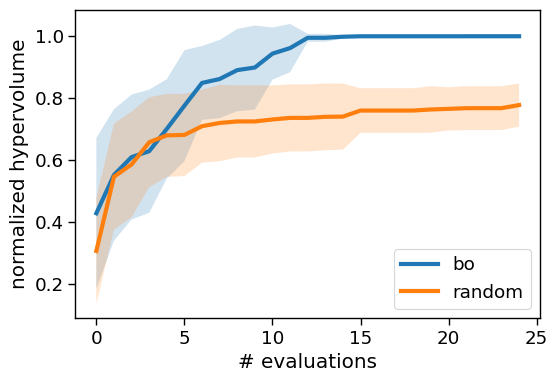

In [52]:
# normalize the hypervolumes
all_hvols = np.array(all_hvols)
all_hvols_rand = np.array(all_hvols_rand)
print(all_hvols.shape, all_hvols_rand.shape)

min_ = np.amin(np.concatenate((all_hvols,all_hvols_rand)))
max_ = np.amax(np.concatenate((all_hvols,all_hvols_rand)))

all_hvols = (np.array(all_hvols) - min_) / (max_-min_)
all_hvols_rand = (np.array(all_hvols_rand) - min_) / (max_-min_)

plt.figure(figsize=(6,4))
plt.plot(np.mean(all_hvols,axis=0), lw=3,label='bo')
plt.fill_between(
  np.arange(25),
  np.mean(all_hvols,axis=0)-np.std(all_hvols,axis=0),
  np.mean(all_hvols,axis=0)+np.std(all_hvols,axis=0),
  alpha=0.2
)
plt.plot(np.mean(all_hvols_rand,axis=0), lw=3,label='random')
plt.fill_between(
  np.arange(25),
  np.mean(all_hvols_rand,axis=0)-np.std(all_hvols_rand,axis=0),
  np.mean(all_hvols_rand,axis=0)+np.std(all_hvols_rand,axis=0),
  alpha=0.2
)
plt.legend()

plt.xlabel('# evaluations')
plt.ylabel('normalized hypervolume')

plt.savefig('moo_general_params.png', dpi=300)

In [34]:
np.array(all_hvols).shape

(5, 10)